# Machine Learning-Based Diabetes Risk Prediction

**Author:** Nazila Fazeli   
**Project Type:** Supervised Classification  
**Focus:** Medical Risk Prediction

## 1. Project Overview

This project focuses on predicting diabetes outcomes using supervised machine learning models. The objective is to systematically evaluate multiple classification approaches under a unified preprocessing and evaluation framework in order to identify robust and well-generalizing models for medical risk prediction.

The workflow follows a structured pipeline including data loading, exploratory data analysis, preprocessing design, feature transformation, model training, hyperparameter tuning, and decision threshold optimization. Performance is assessed using both ROC-AUC and PR-AUC metrics to ensure reliable evaluation under mild class imbalance.

### 1.1 Problem Statement

Diabetes is a chronic medical condition that requires early detection and continuous monitoring to reduce long-term health risks. The task addressed in this project is a binary classification problem, where the goal is to predict whether a patient is likely to be diagnosed with diabetes based on clinical and demographic measurements.

Given the presence of noisy measurements, missing values encoded as zeros, and moderate class imbalance, the challenge lies in building models that achieve strong predictive performance while maintaining stability and generalization capability.

### 1.2 Dataset Description

The dataset consists of clinical and demographic attributes collected from patients, including physiological measurements such as glucose level, insulin concentration, blood pressure, body mass index (BMI), skin thickness, age, and pregnancy count.

Several clinical variables contain zero values that are physiologically implausible and are interpreted as missing or unrecorded measurements. These values are explicitly handled during preprocessing using feature-specific imputation strategies and missingness indicators where appropriate.

In addition, the dataset exhibits moderate class imbalance between diabetic and non-diabetic cases. This imbalance is taken into account during model evaluation by prioritizing threshold-independent metrics such as ROC-AUC and PR-AUC, as well as through post-training threshold optimization.

### 1.3 Project Objectives

The main objectives of this project are:

To design a robust and reusable preprocessing pipeline that prevents data leakage and supports multiple model families.

To evaluate a diverse set of classification models including linear models, instance-based methods, kernel-based models, tree-based algorithms, ensemble methods, and boosting techniques.

To compare models using consistent evaluation metrics with a primary focus on PR-AUC and ROC-AUC.

To perform decision threshold optimization in order to align model outputs with practical classification objectives.

To identify the most reliable model architecture for diabetes risk prediction under realistic data conditions.

### 1.4 Modeling Strategy

The modeling strategy follows a modular and pipeline-based approach. Preprocessing steps are defined separately from model training and reused across different algorithm families to ensure fair comparison and reproducibility.

Models are grouped into families based on their learning characteristics, including linear classifiers, distance-based methods, tree-based models, ensemble learners, and boosting algorithms. Hyperparameter tuning is performed using cross-validation with ROC-AUC as the primary optimization metric.

For models that do not naturally produce well-calibrated probability estimates (such as SVM, KNN, tree-based models, and ensemble methods), probability calibration is applied using cross-validation-based calibration techniques. Calibration is treated as a post-processing step to improve probability reliability rather than to directly optimize classification accuracy. This ensures that predicted probabilities are suitable for downstream threshold-based decision analysis.

Final model evaluation is conducted on a held-out test set, followed by threshold optimization to analyze performance trade-offs between precision and recall. This deployment-oriented evaluation strategy enables transparent comparison, robust performance assessment under class imbalance, and informed model selection for clinical decision support scenarios.


## 2. Technical Setup and Utilities

### 2.1 Imports

In [1]:
# ============================================================
# 📦 Core Scientific Stack
# ============================================================
import numpy as np
import pandas as pd

# ============================================================
# 📊 Visualization
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# 📐 Statistics (optional analysis support)
# ============================================================
import scipy.stats as stats

# ============================================================
# 🤖 Machine Learning — Data Splitting & Validation
# ============================================================
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
    cross_validate
)

# ============================================================
# 🧱 Preprocessing & Pipelines
# ============================================================
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    StandardScaler,
    RobustScaler,
    OneHotEncoder,
    FunctionTransformer,
    PolynomialFeatures
)

# ============================================================
# ⚖️ Classification Models
# ============================================================
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV

# ============================================================
# ⚡ Imbalanced Learning
# ============================================================
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# ============================================================
# 📏 Evaluation Metrics
# ============================================================
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# ============================================================
# 🔍 Model Inspection & Interpretation
# ============================================================
from sklearn.inspection import (
    permutation_importance,
    PartialDependenceDisplay
)

# ============================================================
# 🛠 Utilities & Configuration
# ============================================================
import os
import re
import warnings
from dotenv import load_dotenv
from sqlalchemy import create_engine

from sklearn.exceptions import DataConversionWarning, UndefinedMetricWarning

warnings.filterwarnings(
    "ignore",
    message="Found unknown categories*",
    category=UserWarning
)

# ============================================================
# 🎨 Project Styling & Global Settings
# ============================================================
MAIN_COLOR = "#B388EB"
RANDOM_STATE = 0


### 2.2 Model Evaluation Utilities
This section defines reusable evaluation functions used across
all classification models in this notebook.

The goal is to ensure consistent metric computation, fair model comparison,
and clear visualization of classification performance under class imbalance.

In [2]:

RANDOM_STATE = 0

def metric_report(y_true, y_pred, y_proba=None, label="model"):
    # Basic metrics
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)

    # Specificity (True Negative Rate)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    # ROC-AUC (if probabilities are provided)
    roc = roc_auc_score(y_true, y_proba) if y_proba is not None else None

    # PR-AUC
    if y_proba is not None:
        prec_curve, rec_curve, _ = precision_recall_curve(y_true, y_proba)
        pr_auc = auc(rec_curve, prec_curve)
    else:
        pr_auc = None

    out = {
        "model": label,
        "accuracy": acc,
        "precision": prec,
        "specificity": spec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc,
        "pr_auc": pr_auc
    }
    return out

def plot_roc_pr(y_true, y_score, title_prefix=""):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    rocA = auc(fpr, tpr)
    prec, rec, _ = precision_recall_curve(y_true, y_score)
    prA = auc(rec, prec)

    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={rocA:.3f}")
    plt.plot([0,1],[0,1],"--")
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"{title_prefix} ROC"); plt.legend()
    plt.show()

    plt.figure()
    plt.plot(rec, prec, label=f"AP={prA:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"{title_prefix} Precision-Recall"); plt.legend()
    plt.show()

def show_confusion(y_true, y_pred, title="Confusion Matrix"):
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    plt.title(title); plt.show()

### 2.3 Threshold Optimization Utilities
This section defines reusable tools for selecting and evaluating
decision thresholds based on predicted probabilities.

Threshold optimization is treated as a post-modeling decision step
and is aligned with business objectives such as maximizing recall,
precision, or balanced performance.

In [3]:
# ============================================
# Threshold Optimization Tools (Steps A–C)
# ============================================

# =====================
# Step A — Threshold sweep
# =====================
def threshold_sweep(y_true, y_score, thresholds=None):
    """
    Sweep thresholds and compute metrics using metric_report.
    """
    if thresholds is None:
        thresholds = np.linspace(0.01, 0.99, 99)

    rows = []
    for t in thresholds:
        y_pred = (y_score >= t).astype(int)
        m = metric_report(y_true, y_pred, y_score ,label=f"t={t:.3f}")

        rows.append({
            "threshold": t,
            "accuracy":   m["accuracy"],
            "precision":  m["precision"],
            "specificity": m["specificity"],
            "recall":     m["recall"],
            "f1":         m["f1"],
            "roc_auc":    m["roc_auc"],
            "pr_auc":     m["pr_auc"],
        })
    return pd.DataFrame(rows)


# =====================
# Step B — Choose threshold by objective
# =====================
def choose_threshold_by_objective(sweep_df, objective="f1_max", target=0.8):

    if objective == "f1_max":
        i = sweep_df["f1"].idxmax()
        return float(sweep_df.loc[i, "threshold"]), "F1-max"

    if objective == "precision_at":
        df = sweep_df[sweep_df["precision"] >= target]
        if len(df) == 0:
            return float(sweep_df.iloc[-1]["threshold"]), f"precision_at({target}) — best available"
        i = df["recall"].idxmax()
        return float(df.loc[i, "threshold"]), f"precision≥{target}, max recall"

    if objective == "recall_at":
        df = sweep_df[sweep_df["recall"] >= target]
        if len(df) == 0:
            return float(sweep_df.iloc[-1]["threshold"]), f"recall_at({target}) — best available"
        i = df["precision"].idxmax()
        return float(df.loc[i, "threshold"]), f"recall≥{target}, max precision"

    raise ValueError("Unknown objective")


# =====================
# Step C — Evaluate model at chosen threshold
# =====================
#def show_at_threshold(y_true, y_score, t, label=""):
#   y_pred = (y_score >= t).astype(int)
#    show_confusion(y_true, y_pred, f"{label} (t={t:.2f})")
#    return metric_report(y_true, y_pred, y_score, f"{label} (t={t:.2f})")

# ============================================
def show_at_threshold(y_true, y_score, t, label="", ax=None):
    y_pred = (y_score >= t).astype(int)

    cm = confusion_matrix(y_true, y_pred)

    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))

    ax.imshow(cm, vmin=0, vmax=1)

    green_pastel = "#C2E7C4"
    red_pastel   = "#F0C6C3"

    for i in range(2):
        for j in range(2):
            ax.add_patch(
                plt.Rectangle(
                    (j - 0.5, i - 0.5),
                    1, 1,
                    facecolor=green_pastel if i == j else red_pastel,
                    edgecolor="white"
                )
            )
            ax.text(
                j, i,
                f"{cm[i, j]:.0f}",
                ha="center", va="center",
                fontsize=11,
                color="black"
            )

    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["Pred 0", "Pred 1"], fontsize=9)
    ax.set_yticklabels(["True 0", "True 1"], fontsize=9)

    ax.set_title(f"{label}\n(t = {t:.2f})", fontsize=10)
    ax.set_xlim(-0.5, 1.5)
    ax.set_ylim(1.5, -0.5)

    if ax is None:
        plt.tight_layout()
        plt.show()

    return metric_report(y_true, y_pred, y_score, f"{label} (t={t:.2f})")


 ### 2.4 IQR-Based Outlier Handling Utilities

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

class IQRCapper(BaseEstimator, TransformerMixin):
    def __init__(self, k=1.5):
        self.k = k

    def fit(self, X, y=None):
        # Ensure DataFrame for column-wise operations
        X = pd.DataFrame(X)

        q1 = X.quantile(0.25)
        q3 = X.quantile(0.75)
        iqr = q3 - q1

        self.lower_bounds_ = q1 - self.k * iqr
        self.upper_bounds_ = q3 + self.k * iqr

        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()

        for col in X.columns:
            X[col] = X[col].clip(
                lower=self.lower_bounds_[col],
                upper=self.upper_bounds_[col]
            )

        return X

## 3. Data Preparation

### 3.1 Load Raw Data

In [5]:
load_dotenv(override=True)

DB_STRING = os.getenv("DB_STRING")
engine = create_engine(DB_STRING)

query = """
SELECT
    p."id" AS patient_id,
    p."Age",
    p."bmi",
    p."pregnancies",

    s."skinthickness",

    bm."measurement_date",
    bm."glucose",
    bm."insulin",
    bm."bloodpressure",

    po."diabetespedigreefunction",
    po."outcome"

FROM diabetes."patient" p

LEFT JOIN diabetes."blood_metrics" bm
    ON p."id" = bm."patientid"

LEFT JOIN diabetes."skin" s
    ON p."id" = s."patientid"

LEFT JOIN diabetes."pedigree_outcome" po
    ON p."id" = po."patientid"

ORDER BY p."id", bm."measurement_date";



"""

df_sqlalchemy = pd.read_sql(query, engine)

# Ensure datetime parsing for later checks
df_sqlalchemy["measurement_date"] = pd.to_datetime(df_sqlalchemy["measurement_date"], errors="coerce")

df_sqlalchemy.head()
#df_sqlalchemy.tail()


,patient_id,Age,bmi,pregnancies,skinthickness,measurement_date,glucose,insulin,bloodpressure,diabetespedigreefunction,outcome
0,1,50,33.6,6,35,2022-12-01,172,80,117,0.627,1
1,1,50,33.6,6,35,2022-12-13,148,0,72,0.627,1
2,2,31,26.6,1,29,2022-12-01,54,80,93,0.351,0
3,2,31,26.6,1,29,2022-12-13,85,0,66,0.351,0
4,3,32,23.3,8,0,2022-12-01,168,1,100,0.672,1


In [6]:
df_sqlalchemy.shape


(1536, 11)

In [7]:
df_sqlalchemy["measurement_date"].value_counts()


measurement_date
2022-12-01    768
2022-12-13    768
Name: count, dtype: int64

In [8]:
# Save raw joined dataset for EDA
df_sqlalchemy.to_csv("data/diabetes.csv", index=False)

print("diabetes.csv saved successfully in data folder")

diabetes.csv saved successfully in data folder


### 3.2 Data Filtering / Inspection

In [9]:
df_raw = pd.read_csv("data/diabetes.csv")
df_raw.head()

,patient_id,Age,bmi,pregnancies,skinthickness,measurement_date,glucose,insulin,bloodpressure,diabetespedigreefunction,outcome
0,1,50,33.6,6,35,2022-12-01,172,80,117,0.627,1
1,1,50,33.6,6,35,2022-12-13,148,0,72,0.627,1
2,2,31,26.6,1,29,2022-12-01,54,80,93,0.351,0
3,2,31,26.6,1,29,2022-12-13,85,0,66,0.351,0
4,3,32,23.3,8,0,2022-12-01,168,1,100,0.672,1


In [10]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1536 entries, 0 to 1535
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   patient_id                1536 non-null   int64  
 1   Age                       1536 non-null   int64  
 2   bmi                       1536 non-null   float64
 3   pregnancies               1536 non-null   int64  
 4   skinthickness             1536 non-null   int64  
 5   measurement_date          1536 non-null   object 
 6   glucose                   1536 non-null   int64  
 7   insulin                   1536 non-null   int64  
 8   bloodpressure             1536 non-null   int64  
 9   diabetespedigreefunction  1536 non-null   float64
 10  outcome                   1536 non-null   int64  
dtypes: float64(2), int64(8), object(1)
memory usage: 132.1+ KB


In [11]:
df_raw["measurement_date"].unique()

array(['2022-12-01', '2022-12-13'], dtype=object)

In [12]:
day_groups = df_raw.groupby("measurement_date")

In [13]:
day_groups[["skinthickness","Age","bmi"]].describe().T

measurement_date     2022-12-01  2022-12-13
skinthickness count  768.000000  768.000000
              mean    20.536458   20.536458
              std     15.952218   15.952218
              min      0.000000    0.000000
              25%      0.000000    0.000000
              50%     23.000000   23.000000
              75%     32.000000   32.000000
              max     99.000000   99.000000
Age           count  768.000000  768.000000
              mean    33.240885   33.240885
              std     11.760232   11.760232
              min     21.000000   21.000000
              25%     24.000000   24.000000
              50%     29.000000   29.000000
              75%     41.000000   41.000000
              max     81.000000   81.000000
bmi           count  768.000000  768.000000
              mean    31.992578   31.992578
              std      7.884160    7.884160
              min      0.000000    0.000000
              25%     27.300000   27.300000
              50%     32.000000   32.000000
              75%     36.600000   36.600000
              max     67.100000   67.100000

In [14]:
day_groups[["glucose", "insulin", "bloodpressure"]].describe().T

measurement_date     2022-12-01  2022-12-13
glucose       count  768.000000  768.000000
              mean   102.002604  120.894531
              std     58.325705   31.972618
              min      0.000000    0.000000
              25%     52.750000   99.000000
              50%    105.000000  117.000000
              75%    152.000000  140.250000
              max    200.000000  199.000000
insulin       count  768.000000  768.000000
              mean    48.408854   79.799479
              std     29.322636  115.244002
              min      0.000000    0.000000
              25%     22.000000    0.000000
              50%     49.000000   30.500000
              75%     73.000000  127.250000
              max    100.000000  846.000000
bloodpressure count  768.000000  768.000000
              mean    63.049479   69.105469
              std     35.408035   19.355807
              min      0.000000    0.000000
              25%     32.000000   62.000000
              50%     62.000000   72.000000
              75%     96.000000   80.000000
              max    122.000000  122.000000

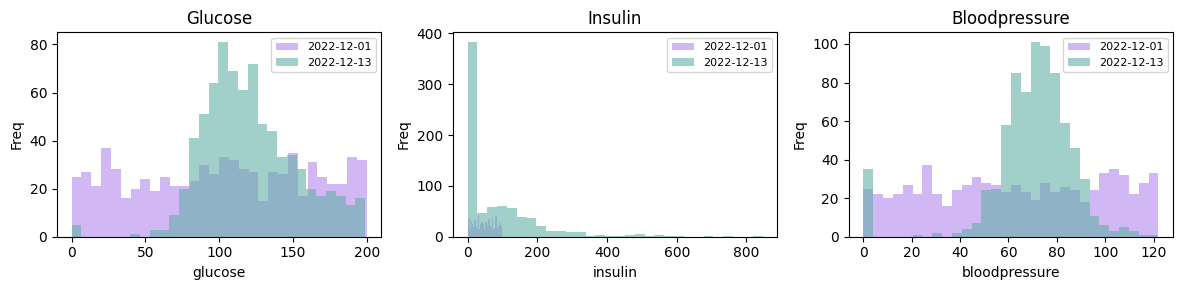

In [15]:
day_groups = df_raw.groupby("measurement_date")

features = ["glucose", "insulin", "bloodpressure"]
colors = ["#B388EB", "#63AFA8FF"]

fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=False)

for ax, feature in zip(axes, features):

    for (date, g), color in zip(day_groups, colors):
        ax.hist(
            g[feature],
            bins=30,
            alpha=0.6,
            label=str(date),
            color=color
        )

    ax.set_title(feature.capitalize())
    ax.set_xlabel(feature)
    ax.set_ylabel("Freq")
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


### Measurement Day Anomaly Analysis

Statistical summaries of **skinthickness, Age, and bmi** showed identical distributions across both measurement days, indicating that these attributes originate from static patient-level data and do not contain temporal anomalies.

In contrast, **glucose, insulin, and bloodpressure** exhibited clear abnormal patterns on **2022-12-01**, suggesting noisy, corrupted, or artificially generated measurements.

#### Suspicious Patterns by Feature

**Glucose**

* Mean on **2022-12-01** is noticeably lower and more irregular compared to **2022-12-13**.
* The distribution shows higher variance and unstable spread on **2022-12-01**, which is inconsistent with controlled clinical measurements.
* This indicates measurement noise or data corruption on that day.

**Insulin**

* Extreme values and highly skewed distribution appear on **2022-12-01**.
* The spread is substantially wider compared to **2022-12-13**, indicating unstable recording behavior.
* This pattern strongly suggests unreliable measurements on **2022-12-01**.

**BloodPressure**

* **2022-12-01** exhibits higher variability and irregular distribution patterns.
* In contrast, **2022-12-13** shows a smoother and more physiologically plausible distribution.
* This further supports the assumption that **2022-12-01** contains noisy measurements.

To further validate these findings, distribution plots were generated for glucose, insulin, and bloodpressure.
The visual comparison clearly confirms **2022-12-13** as the valid measurement day, while **2022-12-01** is identified as the noisy or corrupted measurement day and is therefore excluded from downstream modeling.



### 3.3 Remove Fake Measurement Day

Based on the statistical analysis and distribution comparisons, the measurement batch from **2022-12-01** was identified as corrupted.
All records from this date were removed to ensure that only valid clinical measurements from **2022-12-13** are used for downstream modeling.

In [16]:
# Remove corrupted measurement day (fake batch)
fake_day = "2022-12-01"

# Filter dataset in-place logic (overwrite df)
df = df_raw[df_raw["measurement_date"] != fake_day].copy()

# Sanity check: verify remaining dates
df["measurement_date"].value_counts()

measurement_date
2022-12-13    768
Name: count, dtype: int64

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 768 entries, 1 to 1535
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   patient_id                768 non-null    int64  
 1   Age                       768 non-null    int64  
 2   bmi                       768 non-null    float64
 3   pregnancies               768 non-null    int64  
 4   skinthickness             768 non-null    int64  
 5   measurement_date          768 non-null    object 
 6   glucose                   768 non-null    int64  
 7   insulin                   768 non-null    int64  
 8   bloodpressure             768 non-null    int64  
 9   diabetespedigreefunction  768 non-null    float64
 10  outcome                   768 non-null    int64  
dtypes: float64(2), int64(8), object(1)
memory usage: 72.0+ KB


### 3.4 Train / Test Split

After removing the corrupted measurement batch, the cleaned dataset was split into training and test sets using a stratified split strategy to preserve the class distribution of the target variable.

In [18]:

# Define target variable
y = df["outcome"]

# Define feature matrix (exclude target and ID column)
X = df.drop(columns=["outcome", "patient_id", "measurement_date"])

# Perform stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    random_state=RANDOM_STATE,
    stratify=y
)

# Sanity check
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((614, 8), (154, 8), (614,), (154,))

A 80/20 stratified train–test split was used to preserve class distribution while maximizing training data availability for imbalanced learning and threshold optimization.

### 3.5 Exploratory Analysis for Preprocessing Decisions

In this section, the dataset is explored from a modeling perspective.  
The objective is not to derive business insights, but to examine feature
types, distributions, missing values, and potential data quality issues
in order to make informed preprocessing and transformation decisions.

#### 3.5.1 Feature Overview and Data Types 

In [19]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 614 entries, 45 to 589
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       614 non-null    int64  
 1   bmi                       614 non-null    float64
 2   pregnancies               614 non-null    int64  
 3   skinthickness             614 non-null    int64  
 4   glucose                   614 non-null    int64  
 5   insulin                   614 non-null    int64  
 6   bloodpressure             614 non-null    int64  
 7   diabetespedigreefunction  614 non-null    float64
dtypes: float64(2), int64(6)
memory usage: 43.2 KB


In [20]:
X_train.head(10)

,Age,bmi,pregnancies,skinthickness,glucose,insulin,bloodpressure,diabetespedigreefunction
45,41,39.8,7,0,196,0,90,0.451
995,25,30.1,2,15,81,76,72,0.547
791,25,27.7,2,24,127,275,58,1.600
763,22,20.0,0,22,105,0,68,0.236
517,24,25.9,1,16,193,375,50,0.655
1059,31,24.6,0,0,111,0,65,0.660
131,32,29.0,5,27,99,0,74,0.203
15,29,35.3,10,0,115,0,0,0.134
31,32,30.0,7,0,100,0,0,0.484
1433,31,33.8,3,39,173,185,78,0.970


In [21]:
print("\n=== DESCRIBE (numeric) ===")
display(X_train.select_dtypes(include="number").describe().T)


=== DESCRIBE (numeric) ===


,count,mean,std,min,25%,50%,75%,max
Age,614.0,33.558632,11.884531,21.000,24.0000,30.0000,41.000,81.00
bmi,614.0,31.949837,7.705016,0.000,27.3000,31.9500,36.300,67.10
pregnancies,614.0,3.982085,3.430694,0.000,1.0000,3.0000,6.000,17.00
skinthickness,614.0,20.583062,16.303767,0.000,0.0000,23.0000,33.000,99.00
glucose,614.0,120.679153,31.913878,0.000,100.0000,117.0000,139.750,199.00
insulin,614.0,74.802932,113.488716,0.000,0.0000,0.0000,122.000,846.00
bloodpressure,614.0,69.537459,19.334804,0.000,64.0000,72.0000,80.000,122.00
diabetespedigreefunction,614.0,0.477850,0.342000,0.078,0.2415,0.3745,0.618,2.42


**Observation**

All features are represented using appropriate numeric data types and no explicit type conversion is required at this stage.  
However, an initial inspection reveals the presence of zero values in several clinical variables. Since such values may indicate missing or unrecorded measurements, they are further investigated in the next section.


#### 3.5.2 Zero Value Analysis (Potential Missing Values)

In [22]:
# Columns where zero values are clinically unrealistic
zero_cols = ["glucose", "insulin", "bloodpressure", "skinthickness", "bmi"]

# Count zero values per column
zero_counts = (df[zero_cols] == 0).sum()

# Display results
zero_counts


glucose            5
insulin          374
bloodpressure     35
skinthickness    227
bmi               11
dtype: int64

**Observation: Zero Values and Potential Missing Data**

Zero values were identified in several clinical features. Skinthickness exhibited a particularly high proportion of zero entries, while glucose, insulin, bloodpressure, and bmi contained comparatively fewer zero values.
Because zero is physiologically implausible for these clinical measurements, such entries are interpreted as missing or unrecorded values rather than valid observations.

Accordingly, all zero values in these features are treated as missing data and handled during preprocessing using appropriate imputation strategies to preserve data consistency and model stability.

#### 3.5.3 Duplicate Records and Data Integrity Checks

In [23]:
# Check for fully duplicated rows
n_duplicates = X_train.duplicated().sum()
n_duplicates

0

**Observation**

No duplicate records were detected in the dataset, indicating that each sample represents a unique observation.

#### 3.5.4 Distribution and Outlier Inspection (Training Data Only)

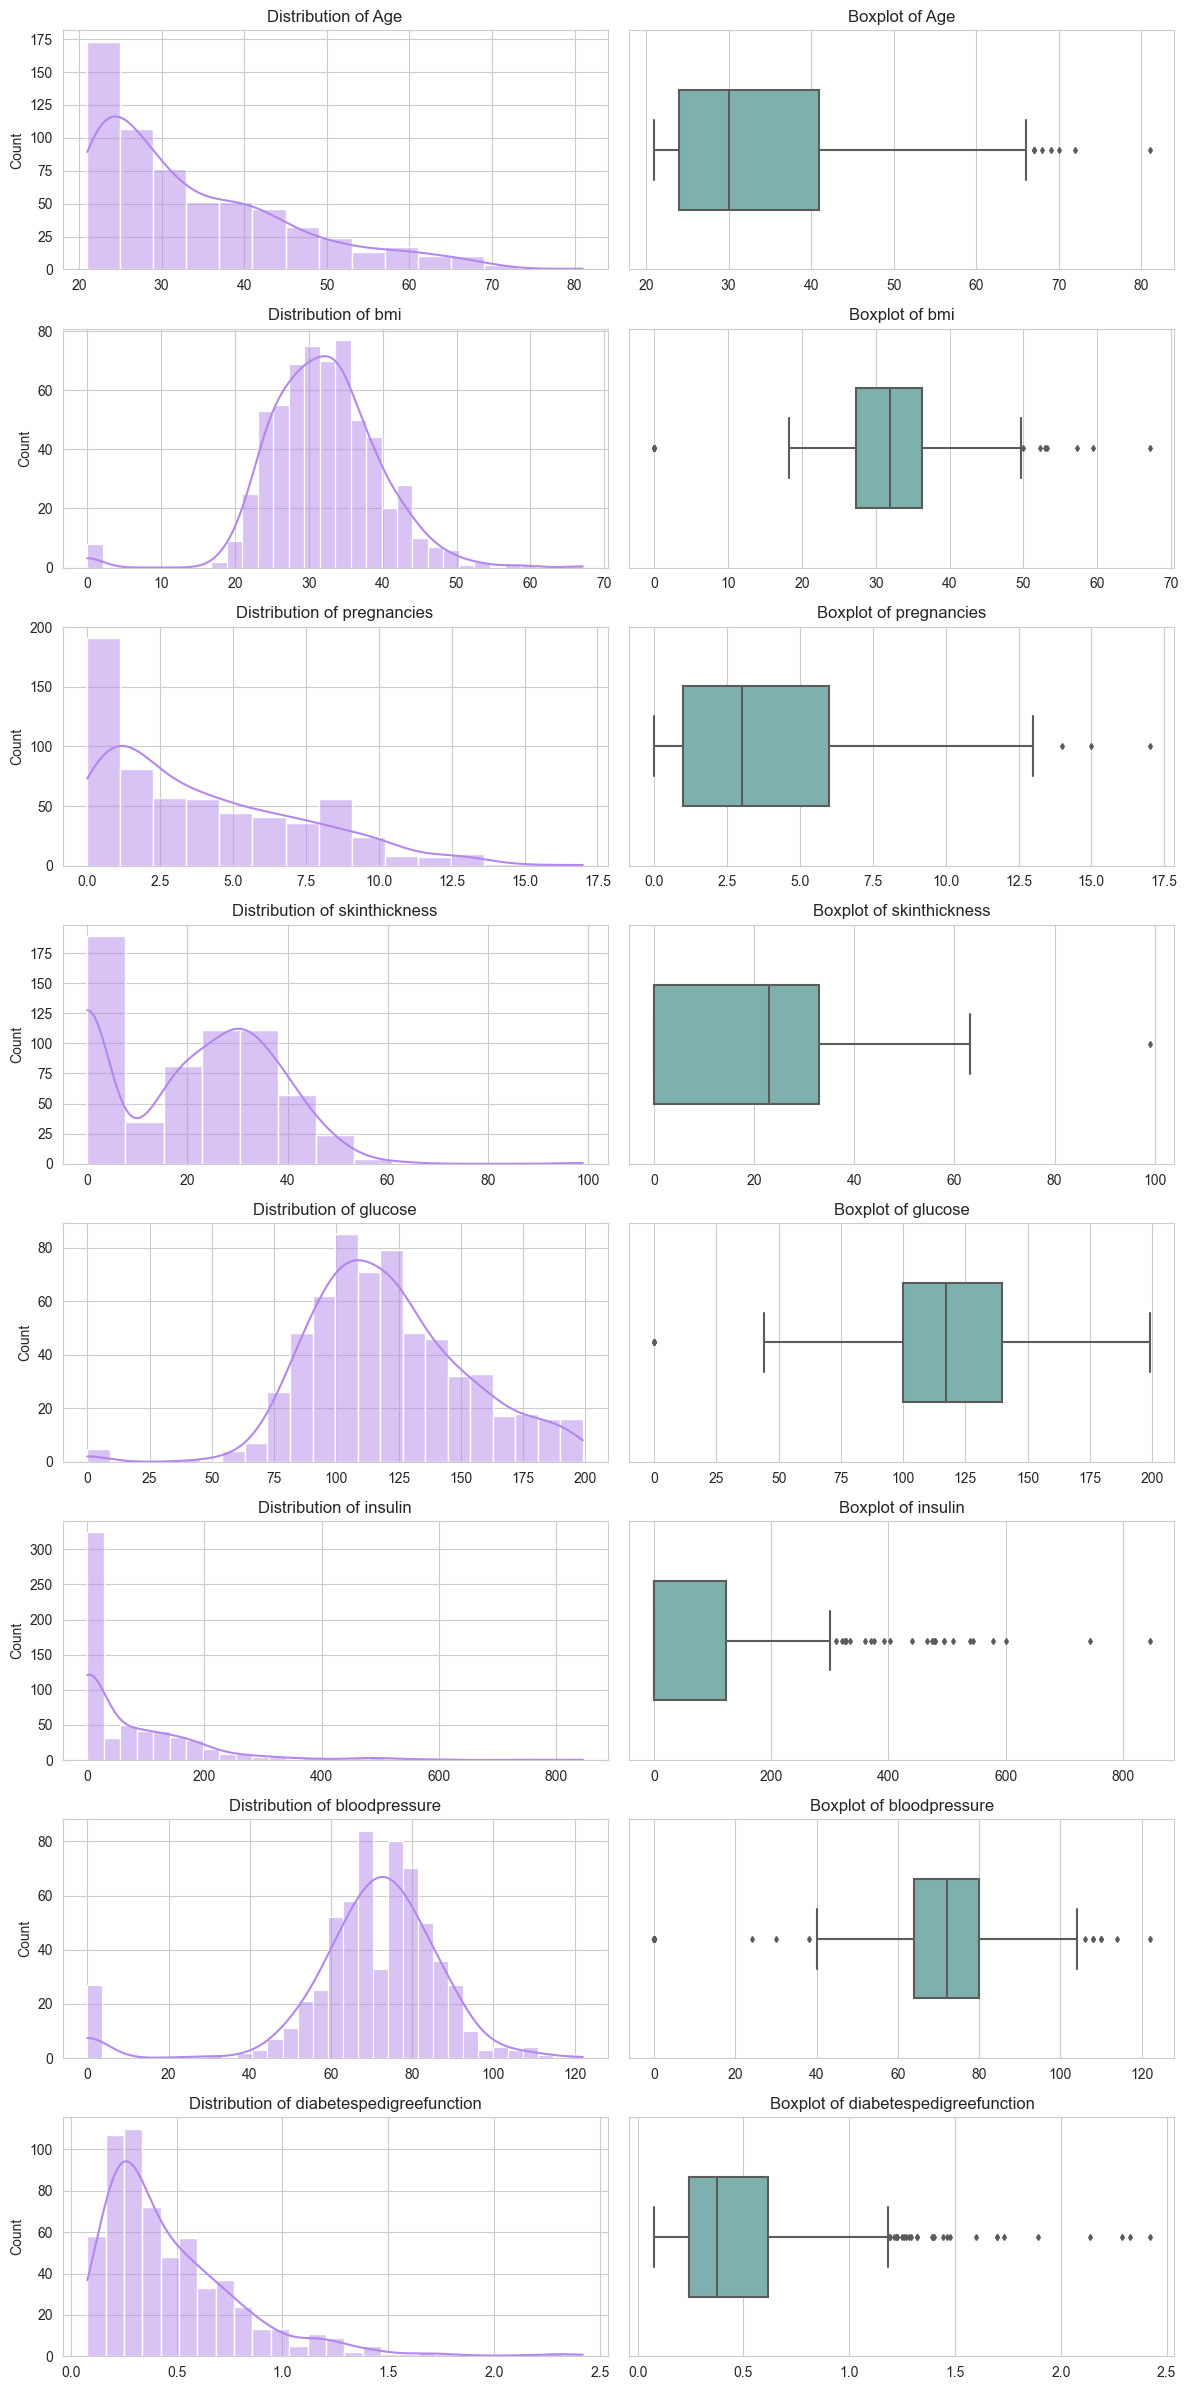

In [69]:

# Numerical features for distribution and outlier inspection
num_cols = [
    "Age",
    "bmi",
    "pregnancies",
    "skinthickness",
    "glucose",
    "insulin",
    "bloodpressure",
    "diabetespedigreefunction"
]

sns.set_style("whitegrid")

fig, axes = plt.subplots(len(num_cols), 2, figsize=(12, 3 * len(num_cols)))

for i, col in enumerate(num_cols):

    # Histogram + KDE plot
    sns.histplot(
        X_train[col],
        kde=True,
        ax=axes[i, 0],
        color= "#B388EB"
    )
    axes[i, 0].set_title(f"Distribution of {col}")
    axes[i, 0].set_xlabel("")

    # Boxplot for outlier detection
    sns.boxplot(
        x=X_train[col],
        ax=axes[i, 1],
        color= "#75BAB4FF",
        width=0.5,
        fliersize=3
    )
    axes[i, 1].set_title(f"Boxplot of {col}")
    axes[i, 1].set_xlabel("")

plt.tight_layout()
plt.show()


### Observation — Feature Distribution Analysis

* **Age**

  * Shows a moderately right-skewed distribution with a small number of high-age outliers.
  * These values appear clinically plausible and should be preserved.
  * Standard scaling is sufficient.

* **bmi**

  * Displays an approximately normal distribution with mild right skew.
  * Contains a few high-value outliers, but no extreme anomalies.
  * Scaling is recommended without removing outliers.

* **pregnancies**

  * Strongly right-skewed and represents a discrete count-based variable.
  * High values are rare but plausible.
  * Scaling helps stabilize its contribution to linear and distance-based models.

* **skinthickness**

  * Exhibits a heavy concentration near zero with a right-skewed tail.
  * This pattern reflects previously identified zero-based missing values.
  * Requires careful imputation followed by robust scaling.

* **glucose**

  * Shows a slightly right-skewed but relatively smooth distribution.
  * No extreme outliers are observed.
  * Standard scaling is sufficient.

* **insulin**

  * Highly right-skewed with extreme high-value outliers.
  * Displays large variance and strong sensitivity to scale.
  * Robust scaling is preferred to reduce the influence of extreme values.

* **bloodpressure**

  * Approximately symmetric with mild right skew.
  * Contains moderate outliers but no abnormal patterns.
  * Standard scaling is adequate.

* **diabetespedigreefunction**

  * Strongly right-skewed with several high-value outliers.
  * Sensitive to extreme values.
  * Robust scaling or log-style transformation is beneficial.


#### 3.5.5 Target Distribution and Class Imbalance  

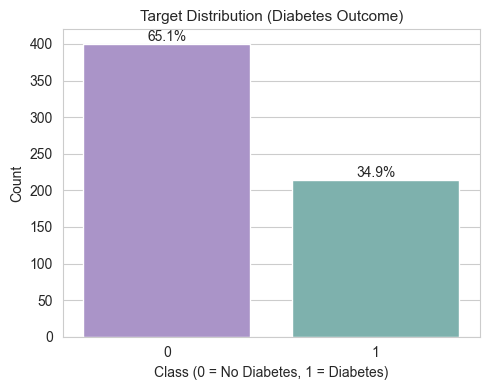

In [65]:
# ----------------------------------
# 3.5.7 Target Distribution and Class Imbalance (Visual)
# ----------------------------------

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
COLOR = "#B388EB"

# Counts and percentages for diabetes outcome
counts = y_train.value_counts().sort_index()
percentages = y_train.value_counts(normalize=True).sort_index() * 100

fig, ax = plt.subplots(figsize=(5, 4))

sns.barplot(
    x=counts.index.astype(str),
    y=counts.values,
    palette=["#A98BD1", "#75BAB4FF"],
    ax=ax
)

ax.set_title("Target Distribution (Diabetes Outcome)", fontsize=11)
ax.set_xlabel("Class (0 = No Diabetes, 1 = Diabetes)")
ax.set_ylabel("Count")

# Add percentage labels on top of bars
for i, (count, pct) in enumerate(zip(counts.values, percentages.values)):
    ax.text(
        i,
        count,
        f"{pct:.1f}%",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.tight_layout()
plt.show()

**Observation**

The target distribution shows a mild class imbalance.  
This imbalance can be effectively addressed by applying class weighting during model training, allowing the classifier to place higher importance on the minority class without introducing synthetic samples.

#### 3.5.6 Insulin Measurement Quality & Missingness Pattern

This section analyzes the measurement quality and missingness pattern of the insulin feature, which exhibits a high proportion of zero values interpreted as missing or unrecorded measurements.

The analysis shows that a substantial fraction of the training samples contain missing insulin values, while the remaining subset with valid insulin measurements exhibits a different class distribution. In particular, diabetes prevalence differs between samples with recorded insulin values and those with missing values, indicating that insulin missingness itself may carry informative signal.

These findings have two important implications for downstream modeling:

1. Insulin values cannot be treated as a standard continuous feature without explicitly handling missingness.  
2. A rule-based baseline model using insulin thresholding (Model 0) can only be applied to the subset of patients with valid insulin measurements and therefore does not represent the full population.

For this reason, insulin is handled separately in the preprocessing pipeline using missing indicators and skew-aware transformations, while the insulin-threshold baseline is evaluated as a specialized reference model rather than a universal classifier.

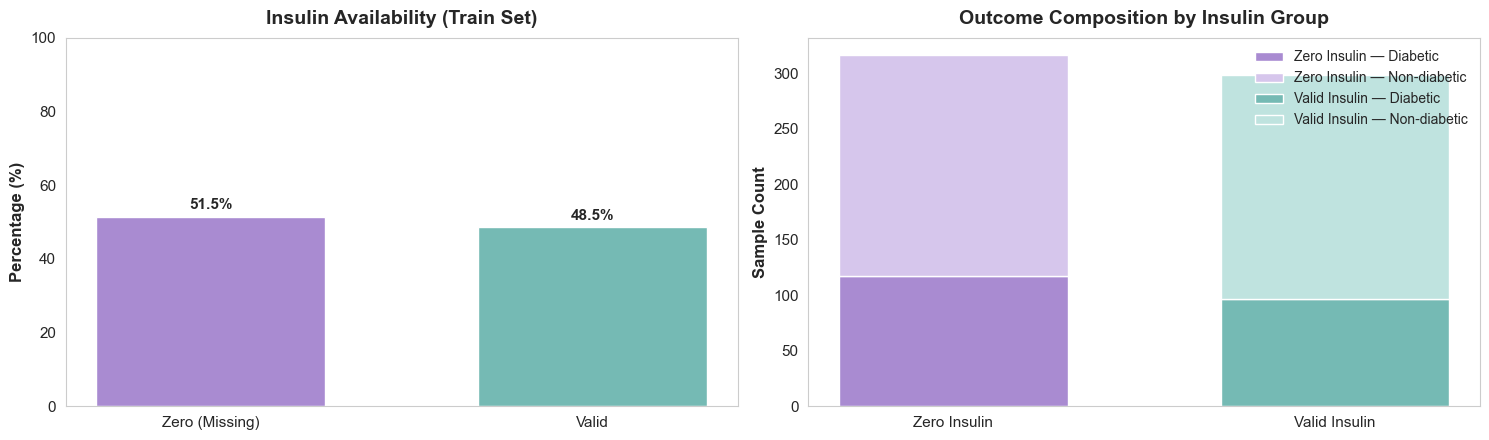

In [26]:
# ==========================================
# Insulin Missingness Analysis (Train Set)
# ==========================================

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Masks
zero_mask  = X_train["insulin"] == 0
valid_mask = X_train["insulin"] > 0

# Percentages of availability
pct_zero  = zero_mask.mean() * 100
pct_valid = valid_mask.mean() * 100

# Outcome counts inside each group
zero_diab_count   = y_train[zero_mask].sum()
zero_non_count    = zero_mask.sum() - zero_diab_count

valid_diab_count  = y_train[valid_mask].sum()
valid_non_count   = valid_mask.sum() - valid_diab_count


# ==========================================
# Side-by-side visualization
# ==========================================

fig, axes = plt.subplots(1, 2, figsize=(15, 4.5))


# =================================================
# Plot 1 — Insulin availability
# =================================================

axes[0].grid(False)

axes[0].bar(
    ["Zero (Missing)", "Valid"],
    [pct_zero, pct_valid],
    color=["#A98BD1", "#75BAB4FF"],
    width=0.6
)

axes[0].set_title(
    "Insulin Availability (Train Set)",
    fontsize=14,
    fontweight="bold",
    pad=10
)

axes[0].set_ylabel(
    "Percentage (%)",
    fontsize=12,
    fontweight="bold"
)

axes[0].set_ylim(0, 100)
axes[0].tick_params(axis="both", labelsize=11)

for i, v in enumerate([pct_zero, pct_valid]):
    axes[0].text(
        i, v + 2,
        f"{v:.1f}%",
        ha="center",
        fontsize=11,
        fontweight="bold"
    )


# =================================================
# Plot 2 — Outcome composition inside groups
# =================================================

axes[1].grid(False)

labels = ["Zero Insulin", "Valid Insulin"]

diabetic_counts     = [zero_diab_count, valid_diab_count]
non_diabetic_counts = [zero_non_count, valid_non_count]

# Base colors (group identity)
zero_color  = "#A98BD1"     # purple
valid_color = "#75BAB4FF"  # green

# Lighter shades (same group, different outcome)
zero_light  = "#D6C6EC"
valid_light = "#BFE3DFFF"


# Diabetic bars
axes[1].bar(
    labels,
    diabetic_counts,
    color=[zero_color, valid_color],
    width=0.6
)

# Non-diabetic bars (stacked)
axes[1].bar(
    labels,
    non_diabetic_counts,
    bottom=diabetic_counts,
    color=[zero_light, valid_light],
    width=0.6
)


axes[1].set_title(
    "Outcome Composition by Insulin Group",
    fontsize=14,
    fontweight="bold",
    pad=10
)

axes[1].set_ylabel(
    "Sample Count",
    fontsize=12,
    fontweight="bold"
)

axes[1].tick_params(axis="both", labelsize=11)


# =================================================
# Custom legend (clear + consistent)
# =================================================

legend_elements = [
    Patch(facecolor=zero_color, label="Zero Insulin — Diabetic"),
    Patch(facecolor=zero_light, label="Zero Insulin — Non-diabetic"),
    Patch(facecolor=valid_color, label="Valid Insulin — Diabetic"),
    Patch(facecolor=valid_light, label="Valid Insulin — Non-diabetic"),
]

axes[1].legend(
    handles=legend_elements,
    fontsize=10,
    frameon=False,
    loc="upper right"
)


plt.tight_layout()
plt.show()


#### 3.5.7 Feature–Feature and Feature–Target Correlation Analysis

#### 1) Correlation Matrix (including target)

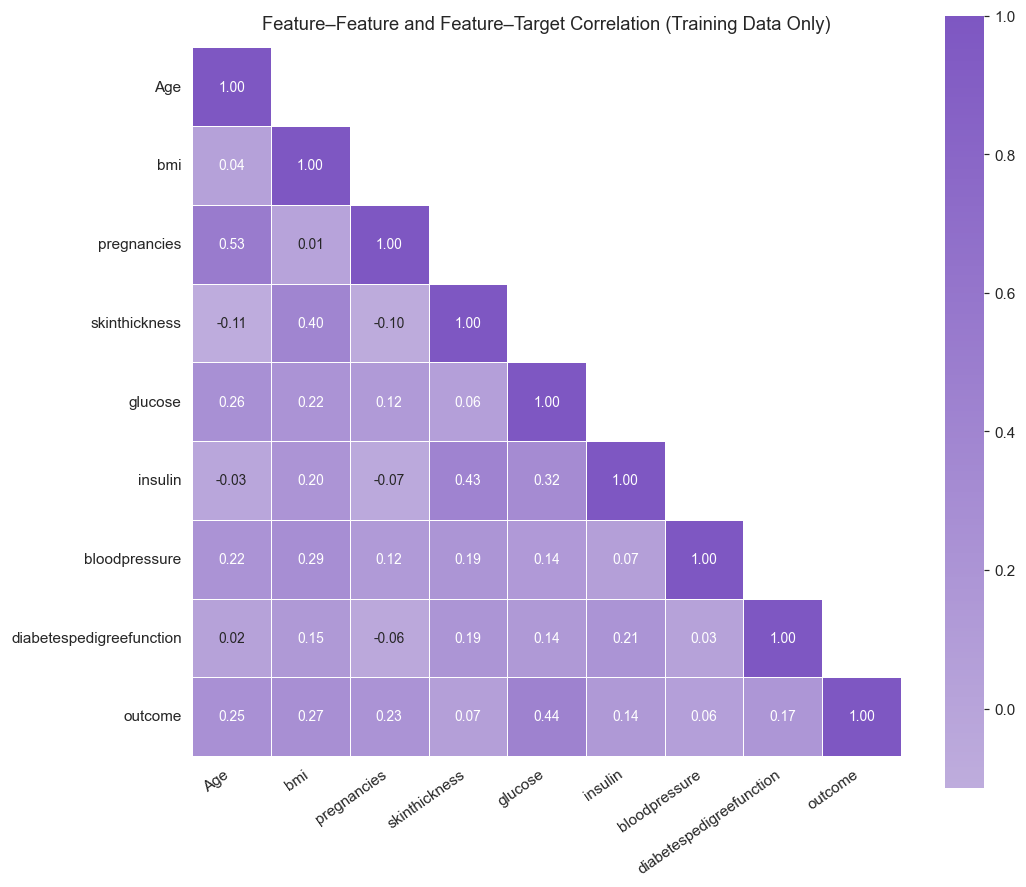

In [27]:
# ----------------------------------
# 3.5.8 Correlation Analysis (Readable Half Matrix incl. Target)
# ----------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")

# Features + target
corr_cols = [
    "Age",
    "bmi",
    "pregnancies",
    "skinthickness",
    "glucose",
    "insulin",
    "bloodpressure",
    "diabetespedigreefunction"
]

# Combine training features with target variable
corr_df = pd.concat(
    [X_train[corr_cols], y_train.rename("outcome")],
    axis=1
)

# Compute correlation matrix (including target)
corr = corr_df.corr()

# Mask upper triangle for readability
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

# Color palette
cmap = sns.light_palette("#7E57C2", as_cmap=True)

# Plot
fig, ax = plt.subplots(figsize=(10, 10), dpi=110)

sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 9},
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.75},
    ax=ax
)

# Remove borders
for spine in ax.spines.values():
    spine.set_visible(False)

# Rotate labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=35, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

ax.set_title("Feature–Feature and Feature–Target Correlation (Training Data Only)", pad=12)

plt.tight_layout()
plt.show()


**Observation — Correlation Analysis**

* **Glucose** shows the strongest positive correlation with the target (**outcome ≈ 0.44**), indicating it is the most informative single predictor for diabetes risk.

* **BMI**, **Age**, and **Pregnancies** exhibit moderate positive correlations with the target (≈ 0.23–0.27), suggesting meaningful but secondary predictive contributions.

* **Insulin** and **DiabetesPedigreeFunction** display weak-to-moderate correlations with the target, indicating complementary rather than dominant predictive roles.

* **BloodPressure** and **SkinThickness** show very weak correlations with the outcome, implying limited standalone predictive power.

* Feature–feature correlations remain generally low to moderate, with no strong multicollinearity observed. This supports retaining all variables for modeling without requiring aggressive feature removal.


#### 2) Pair Plot: Feature vs Target

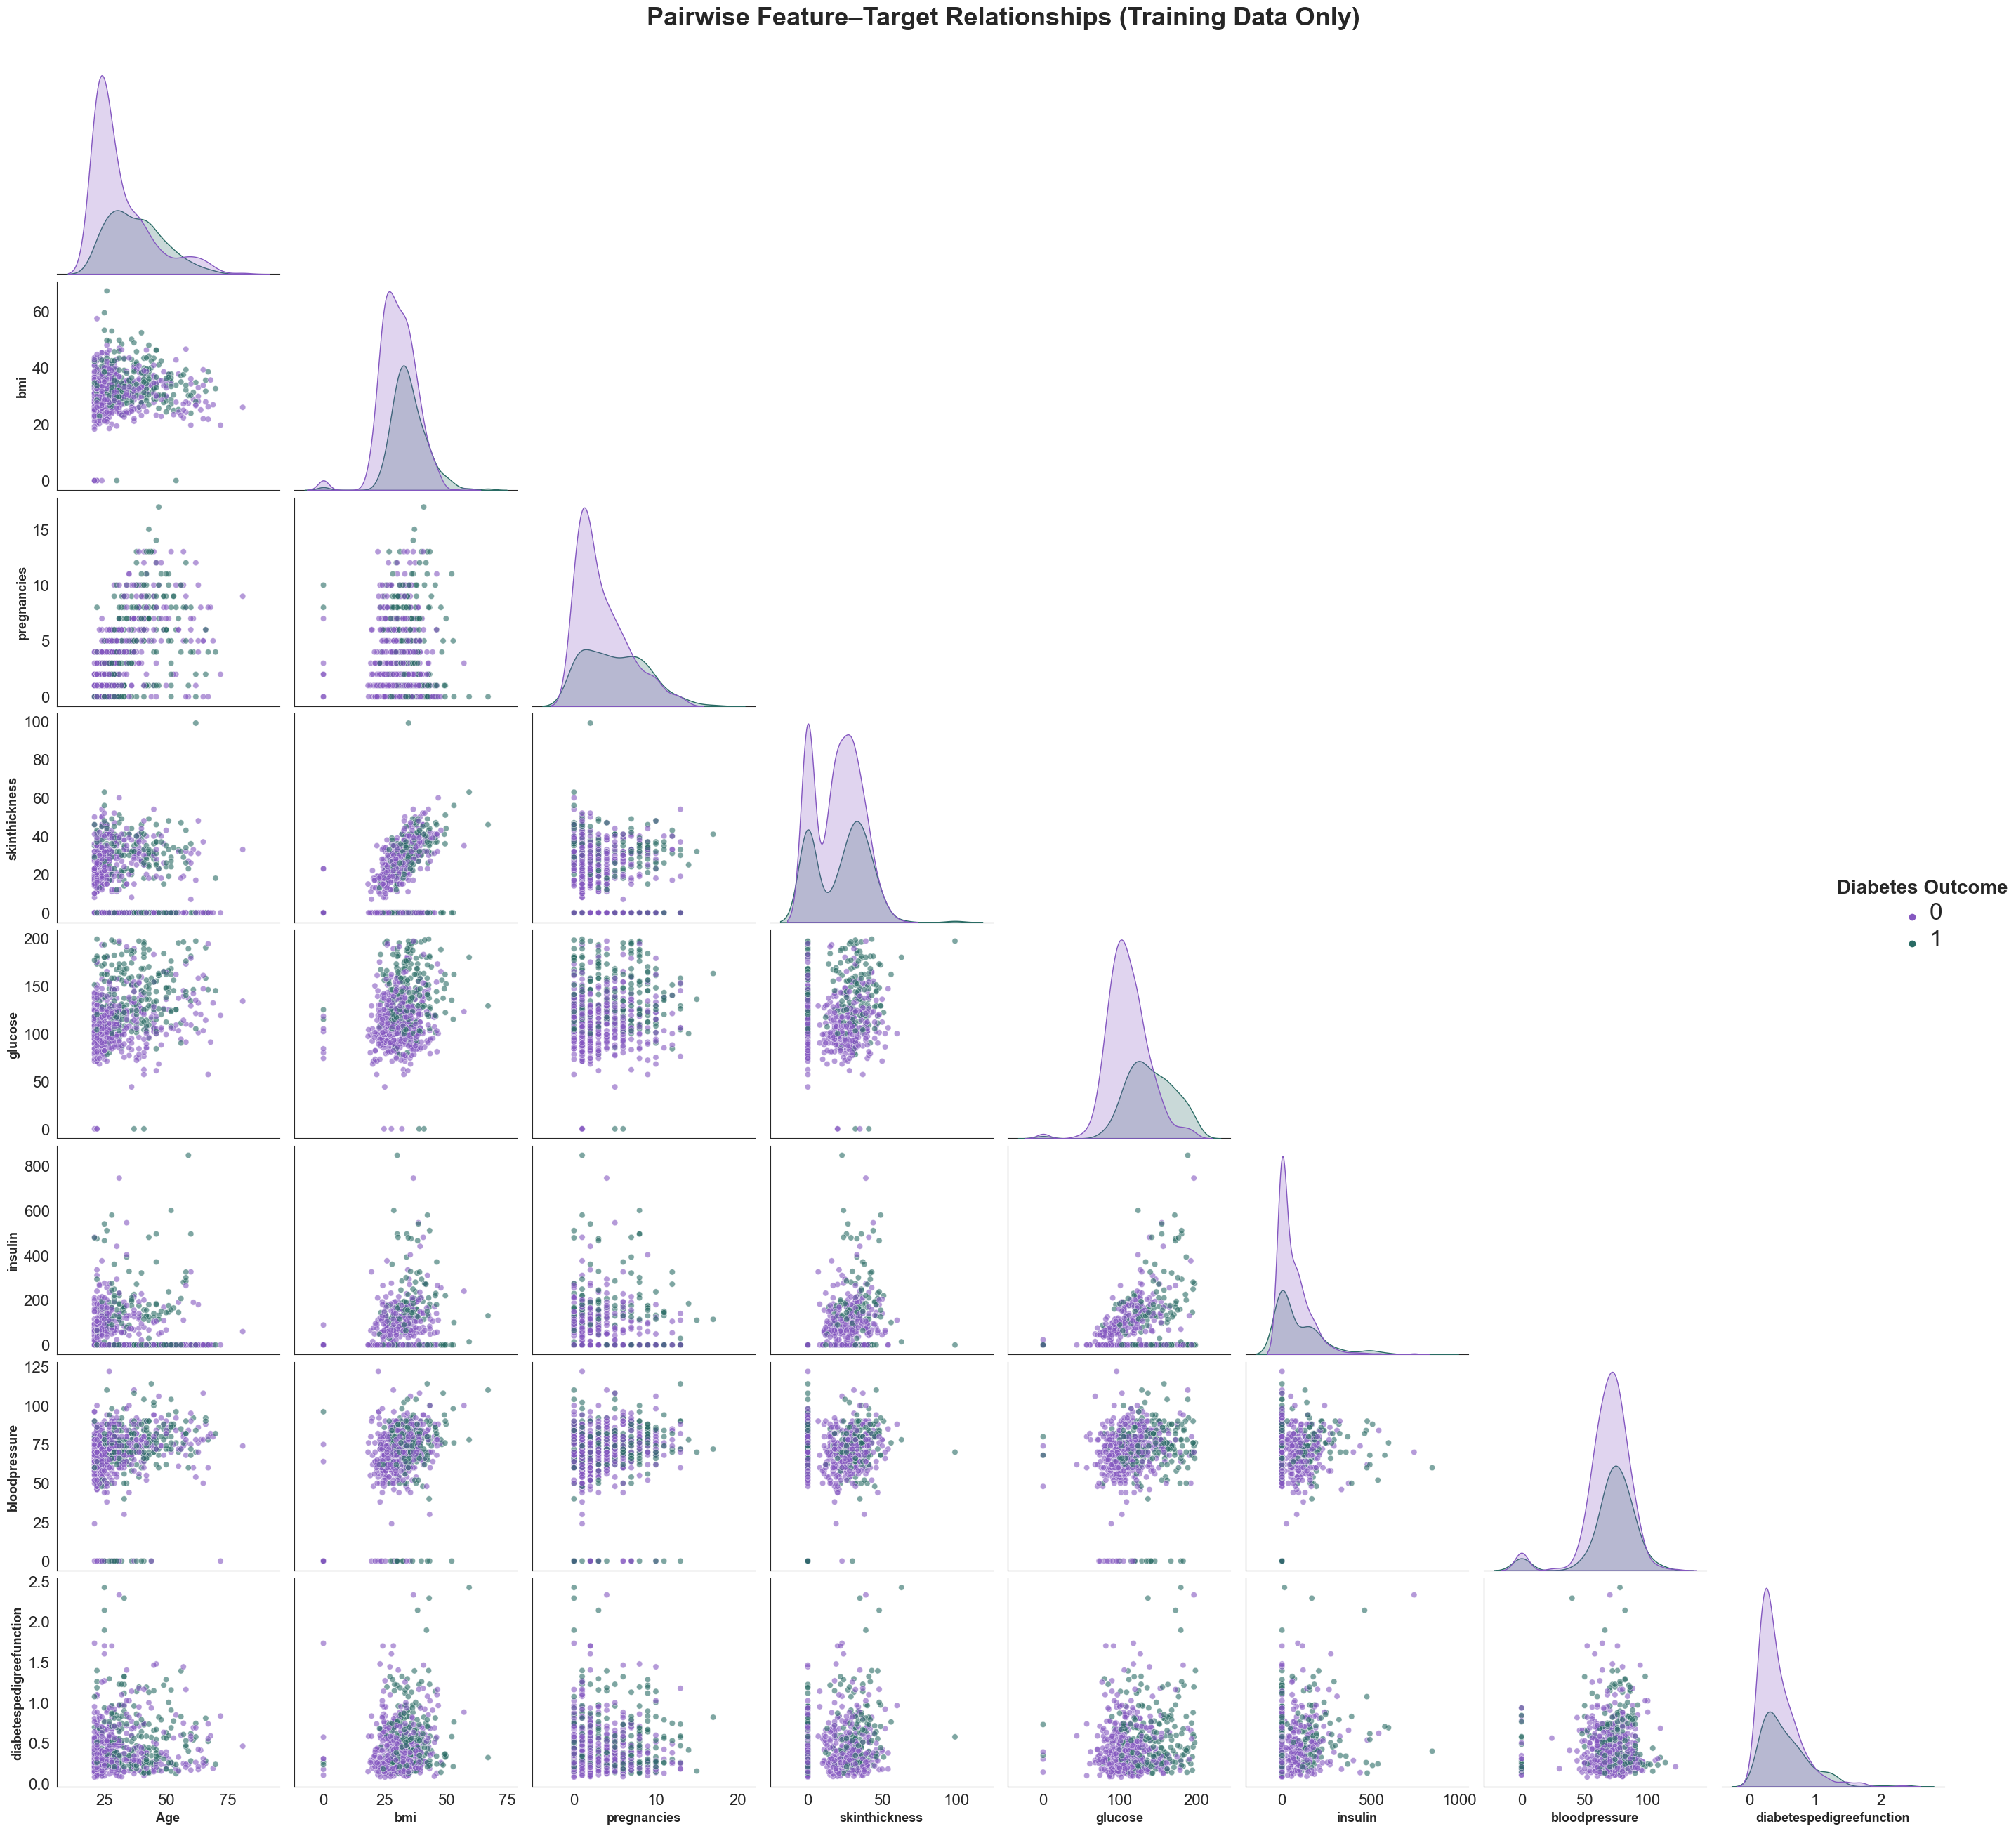

In [28]:
# ----------------------------------
# Pair Plot: Feature vs Target (Training Data Only)
# ----------------------------------

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

pair_cols = [
    "Age",
    "bmi",
    "pregnancies",
    "skinthickness",
    "glucose",
    "insulin",
    "bloodpressure",
    "diabetespedigreefunction",
    "outcome"
]

# Combine training features with target
pair_df = pd.concat(
    [X_train[pair_cols[:-1]], y_train.rename("outcome")],
    axis=1
)

g = sns.pairplot(
    pair_df,
    hue="outcome",
    corner=True,
    diag_kind="kde",
    palette=["#8457C0", "#296B64FF"],
    plot_kws={"alpha": 0.6},
    height=3.2,     # size of each subplot
    aspect=1.1
)

# Improve axis label readability
for ax in g.axes.flatten():
    if ax is not None:
        ax.xaxis.label.set_size(13)
        ax.yaxis.label.set_size(13)
        ax.xaxis.label.set_weight("bold")
        ax.yaxis.label.set_weight("bold")

# Improve legend readability
if g._legend is not None:
    g._legend.set_title("Diabetes Outcome", prop={"size": 20, "weight": "bold"})
    for text in g._legend.texts:
        text.set_fontsize(24)

# Improve tick labels
for ax in g.axes.flatten():
    if ax is not None:
        ax.tick_params(labelsize=16)

# Title
g.fig.suptitle(
    "Pairwise Feature–Target Relationships (Training Data Only)",
    fontsize=26,
    fontweight="bold",
    y=1.02
)

plt.show()


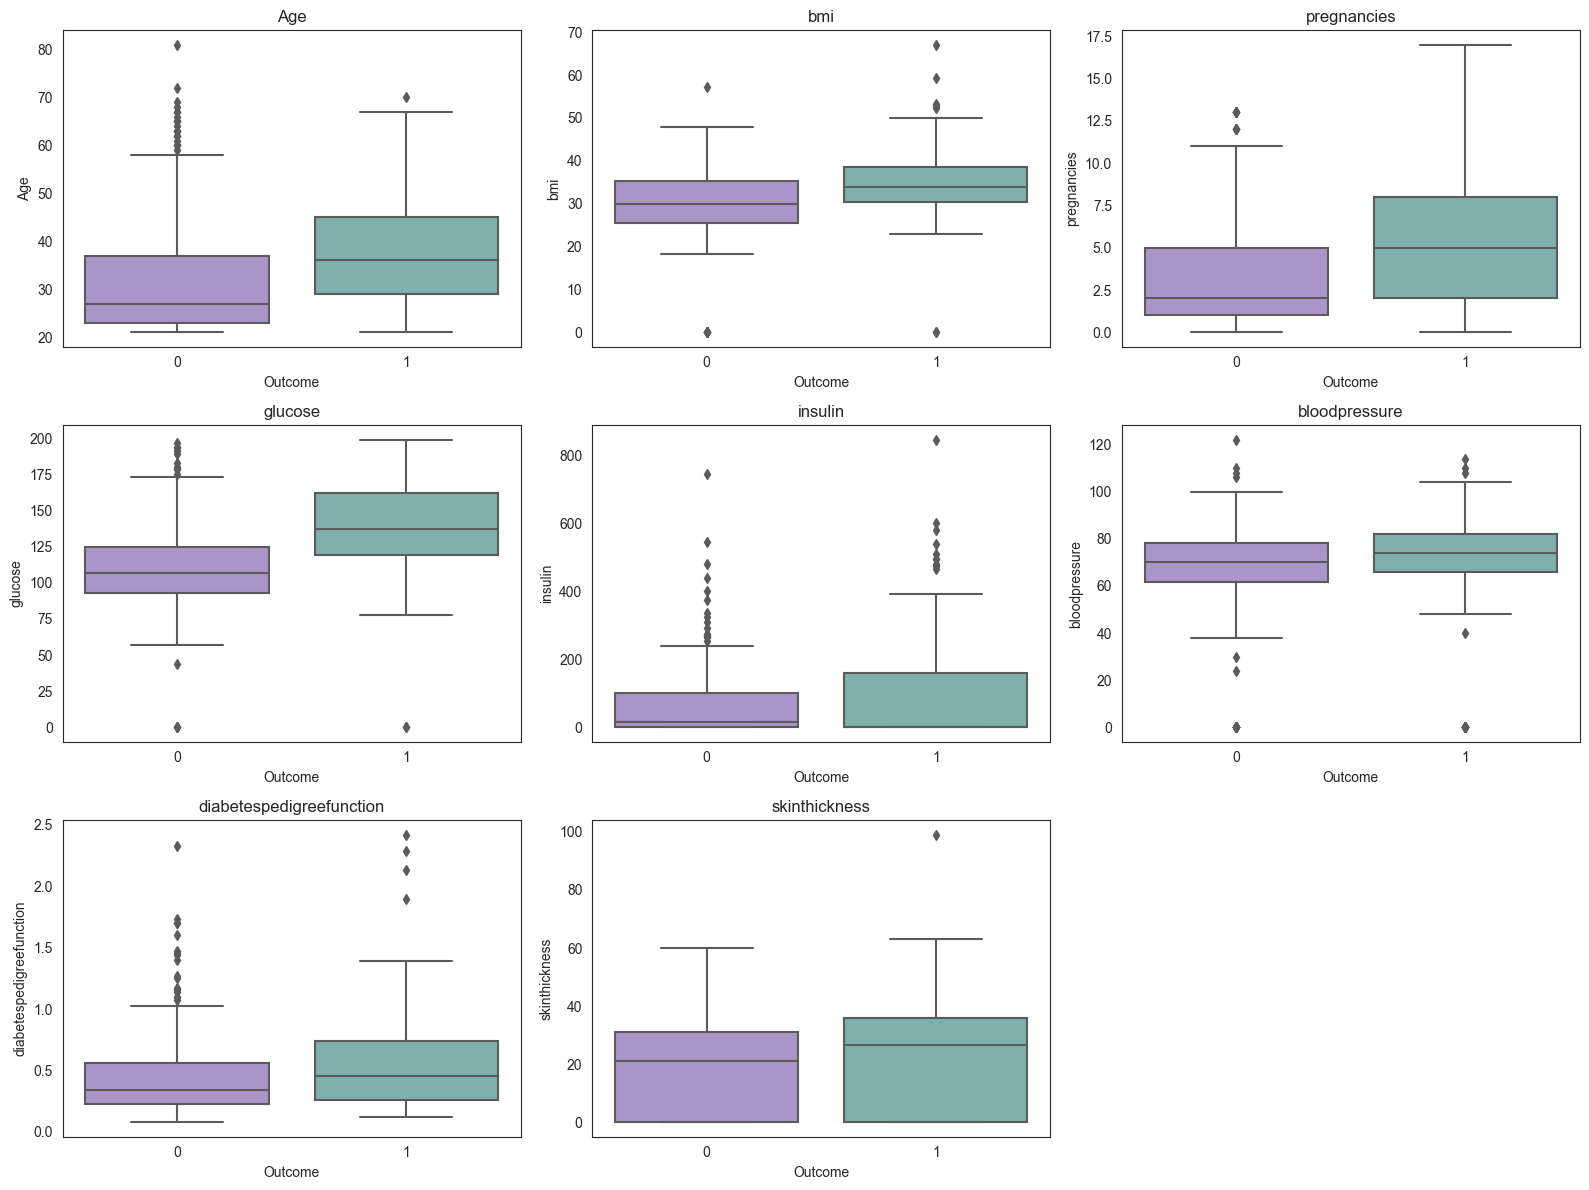

In [29]:
features = [
    "Age", "bmi", "pregnancies", "glucose",
    "insulin", "bloodpressure", "diabetespedigreefunction", "skinthickness"
]

fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.flatten()

for ax, col in zip(axes, features):
    sns.boxplot(
        x=y_train,
        y=X_train[col],
        ax=ax,
        palette=["#A98BD1", "#75BAB4FF"]
    )
    ax.set_title(col)
    ax.set_xlabel("Outcome")

# Turn off unused subplots
for i in range(len(features), len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.show()


**Observation — Correlation Analysis**

- **Glucose** shows the strongest positive correlation with the target (**outcome ≈ 0.44**), indicating it is the most informative single predictor for diabetes risk.

- **BMI**, **Age**, and **Pregnancies** exhibit moderate positive correlations with the target (≈ 0.23–0.27), suggesting meaningful but secondary predictive contributions.

- **Insulin** and **DiabetesPedigreeFunction** display weak-to-moderate correlations with the target, indicating complementary rather than dominant predictive roles.

- **BloodPressure** and **SkinThickness** show very weak correlations with the outcome, implying limited standalone predictive power.

- Feature–feature correlations remain generally low to moderate, with no strong multicollinearity observed. This supports retaining all variables for modeling without requiring aggressive feature removal.


### 3.6 Feature Engineering and Preprocessing Design

#### 3.6.1 Feature Grouping

Input features were grouped based on their distribution characteristics, missing value patterns, and clinical interpretation in order to enable targeted preprocessing strategies.

Clinical measurements were divided into three subgroups:

- **Core clinical measurements (glucose, bloodpressure, bmi)**  
  These features exhibit low missing rates and moderate skewness. Zero values were treated as missing and imputed using the median, followed by scaling to harmonize feature ranges.

- **Clinical features with informative missingness (insulin, skinthickness)**  
  These variables contain a high proportion of missing values represented as zeros and show strong right-skewed distributions.  
  In addition to imputation and scaling, missing indicator features were introduced to explicitly capture whether a measurement was originally missing. This allows the models to learn potential predictive patterns related to unrecorded clinical tests.

- **Skewed derived clinical feature (diabetespedigreefunction)**  
  This feature exhibits strong right skewness but does not contain missing values. A logarithmic transformation combined with scaling was applied to stabilize the distribution.

Demographic and count-based features (**Age, pregnancies**) were handled separately, as they contain no missing values and mainly require scaling for numerical stability.

This structured grouping enables consistent, leakage-safe preprocessing while preserving clinically meaningful information and improving model robustness.


In [30]:
# ----------------------------------
# 3.6.1 Feature Grouping
# ----------------------------------

# -------------------------------------------------
# Group A — Core clinical measurements
# Low missing rate, moderate skew
# Require: zero-as-missing handling + imputation + scaling
# -------------------------------------------------

clinical_main_features = [
    "glucose",
    "bloodpressure",
    "bmi"
]


# -------------------------------------------------
# Group B — Clinical features with informative missingness
# High missing rate + strong skew
# Require: zero-as-missing handling + imputation + missing indicator
#          + log transform + robust scaling
# -------------------------------------------------

clinical_missing_heavy_features = [
    "insulin",
    "skinthickness"
]


# -------------------------------------------------
# Group C — Skewed derived clinical features
# No missing values but strong right skew
# Require: log transform + scaling
# -------------------------------------------------

clinical_skew_only_features = [
    "diabetespedigreefunction"
]


# -------------------------------------------------
# Group D — Demographic and count-based features
# No missing values
# Require: scaling only
# -------------------------------------------------

demographic_features = [
    "Age",
    "pregnancies"
]


# -------------------------------------------------
# Sanity check
# -------------------------------------------------

(
    clinical_main_features,
    clinical_missing_heavy_features,
    clinical_skew_only_features,
    demographic_features
)



(['glucose', 'bloodpressure', 'bmi'],
 ['insulin', 'skinthickness'],
 ['diabetespedigreefunction'],
 ['Age', 'pregnancies'])

#### 3.6.2 Pipeline Design

In [31]:
# ============================================================
# 3.6.2 Preprocessing Pipelines by Model Family — Diabetes Classification
# ============================================================


# ============================================================
# Family 1 — Linear & Distance-Based Models
# (Logistic Regression, SVM, KNN)
# ============================================================

linear_distance_pipelines = {

    # Group A — Core clinical measurements
    "clinical_main": Pipeline([
        ("imputer", SimpleImputer(missing_values=0, strategy="median")),
        ("scaler", StandardScaler())
    ]),

    # Group B — Informative missingness + heavy skew
    "clinical_missing_heavy": Pipeline([
        ("imputer", SimpleImputer(
            missing_values=0,
            strategy="median",
            add_indicator=True
        )),
        ("log", FunctionTransformer(np.log1p, feature_names_out="one-to-one")),
        ("scaler", RobustScaler())
    ]),

    # Group C — Skewed derived clinical feature
    "clinical_skew_only": Pipeline([
        ("log", FunctionTransformer(np.log1p, feature_names_out="one-to-one")),
        ("scaler", StandardScaler())
    ]),

    # Group D — Demographic / count-based features
    "demographic": Pipeline([
        ("scaler", StandardScaler())
    ])
}


# ============================================================
# Family 2 — Polynomial Models
# ============================================================

poly_pipelines = {

    "clinical_main": Pipeline([
        ("imputer", SimpleImputer(missing_values=0, strategy="median")),
        ("poly", PolynomialFeatures(degree=2, include_bias=False)),
        ("scaler", StandardScaler())
    ]),

    "clinical_missing_heavy": Pipeline([
        ("imputer", SimpleImputer(
            missing_values=0,
            strategy="median",
            add_indicator=True
        )),
        ("log", FunctionTransformer(np.log1p, feature_names_out="one-to-one")),
        ("poly", PolynomialFeatures(degree=2, include_bias=False)),
        ("scaler", RobustScaler())
    ]),

    "clinical_skew_only": Pipeline([
        ("log", FunctionTransformer(np.log1p, feature_names_out="one-to-one")),
        ("poly", PolynomialFeatures(degree=2, include_bias=False)),
        ("scaler", StandardScaler())
    ]),

    "demographic": Pipeline([
        ("scaler", StandardScaler())
    ])
}


# ============================================================
# Family 3 — Tree-Based Models
# ============================================================

tree_pipelines = {

    "clinical_main": Pipeline([
        ("imputer", SimpleImputer(missing_values=0, strategy="median"))
    ]),

    "clinical_missing_heavy": Pipeline([
        ("imputer", SimpleImputer(
            missing_values=0,
            strategy="median",
            add_indicator=True
        ))
    ]),

    "clinical_skew_only": "passthrough",

    "demographic": "passthrough"
}


#### 3.6.3 ColumnTransformer 

In [32]:
# ============================================================
# 3.6.3 ColumnTransformer Assembly
# ============================================================


# ============================================================
# ColumnTransformer — Linear & Distance-Based Models
# (Logistic Regression, SVM, KNN)
# ============================================================

preprocessor_linear = ColumnTransformer(
    transformers=[
        ("clinical_main",
         linear_distance_pipelines["clinical_main"],
         clinical_main_features),

        ("clinical_missing_heavy",
         linear_distance_pipelines["clinical_missing_heavy"],
         clinical_missing_heavy_features),

        ("clinical_skew_only",
         linear_distance_pipelines["clinical_skew_only"],
         clinical_skew_only_features),

        ("demographic",
         linear_distance_pipelines["demographic"],
         demographic_features)
    ]
)


# ============================================================
# ColumnTransformer — Polynomial Models
# ============================================================

preprocessor_poly = ColumnTransformer(
    transformers=[
        ("clinical_main",
         poly_pipelines["clinical_main"],
         clinical_main_features),

        ("clinical_missing_heavy",
         poly_pipelines["clinical_missing_heavy"],
         clinical_missing_heavy_features),

        ("clinical_skew_only",
         poly_pipelines["clinical_skew_only"],
         clinical_skew_only_features),

        ("demographic",
         poly_pipelines["demographic"],
         demographic_features)
    ]
)


# ============================================================
# ColumnTransformer — Tree-Based Models
# ============================================================

preprocessor_tree = ColumnTransformer(
    transformers=[
        ("clinical_main",
         tree_pipelines["clinical_main"],
         clinical_main_features),

        ("clinical_missing_heavy",
         tree_pipelines["clinical_missing_heavy"],
         clinical_missing_heavy_features),

        ("clinical_skew_only",
         tree_pipelines["clinical_skew_only"],
         clinical_skew_only_features),

        ("demographic",
         tree_pipelines["demographic"],
         demographic_features)
    ]
)


In [33]:
preprocessor_linear 

ColumnTransformer(transformers=[('clinical_main',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(missing_values=0,
                                                                strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['glucose', 'bloodpressure', 'bmi']),
                                ('clinical_missing_heavy',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                missing_values=0,
                                                                strategy='median')),
                                                 ('log',
                                                  FunctionTransformer(feature_...to-one',
                                                                      func=<ufunc 'log1p'>)),
                                                 ('scaler', RobustScaler())]),
                                 ['insulin', 'skinthickness']),
                                ('clinical_skew_only',
                                 Pipeline(steps=[('log',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<ufunc 'log1p'>)),
                                                 ('scaler', StandardScaler())]),
                                 ['diabetespedigreefunction']),
                                ('demographic',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['Age', 'pregnancies'])])

In [34]:
preprocessor_poly 

ColumnTransformer(transformers=[('clinical_main',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(missing_values=0,
                                                                strategy='median')),
                                                 ('poly',
                                                  PolynomialFeatures(include_bias=False)),
                                                 ('scaler', StandardScaler())]),
                                 ['glucose', 'bloodpressure', 'bmi']),
                                ('clinical_missing_heavy',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                missing_values=0,
                                                                strateg...
                                                 ('scaler', RobustScaler())]),
                                 ['insulin', 'skinthickness']),
                                ('clinical_skew_only',
                                 Pipeline(steps=[('log',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<ufunc 'log1p'>)),
                                                 ('poly',
                                                  PolynomialFeatures(include_bias=False)),
                                                 ('scaler', StandardScaler())]),
                                 ['diabetespedigreefunction']),
                                ('demographic',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['Age', 'pregnancies'])])

In [35]:
preprocessor_tree

ColumnTransformer(transformers=[('clinical_main',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(missing_values=0,
                                                                strategy='median'))]),
                                 ['glucose', 'bloodpressure', 'bmi']),
                                ('clinical_missing_heavy',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                missing_values=0,
                                                                strategy='median'))]),
                                 ['insulin', 'skinthickness']),
                                ('clinical_skew_only', 'passthrough',
                                 ['diabetespedigreefunction']),
                                ('demographic', 'passthrough',
                                 ['Age', 'pregnancies'])])

#### 3.6.4 Post-Preprocessing Distribution Inspection (Pipeline Sanity Check)

In [36]:
# ================================
# Fit + transform (training data)
# ================================

X_train_linear_transformed = preprocessor_linear.fit_transform(X_train)


# ================================
# Extract feature names (robust method)
# ================================

feature_names = preprocessor_linear.get_feature_names_out()

# Remove sklearn prefixes for readability
feature_names = [name.split("__")[-1] for name in feature_names]


# ================================
# Build DataFrame for inspection
# ================================

X_train_linear_df = pd.DataFrame(
    X_train_linear_transformed,
    columns=feature_names,
    index=X_train.index
)

X_train_linear_df.head()


,glucose,bloodpressure,bmi,insulin,skinthickness,missingindicator_insulin,missingindicator_skinthickness,diabetespedigreefunction,Age,pregnancies
45,2.482284,1.408337,1.098401,0.000000,0.000000,0.0,1.0,0.019126,0.626649,0.880398
995,-1.356647,-0.057288,-0.334959,-0.496437,-2.869113,-1.0,0.0,0.335504,-0.720736,-0.578221
791,0.178925,-1.197219,-0.689605,0.780159,-0.933142,-1.0,0.0,2.899497,-0.720736,-0.578221
763,-0.555479,-0.382983,-1.827427,0.000000,-1.294848,0.0,0.0,-0.772860,-0.973371,-1.161669
517,2.382138,-1.848608,-0.955590,1.089347,-2.606127,-1.0,0.0,0.668765,-0.804948,-0.869945


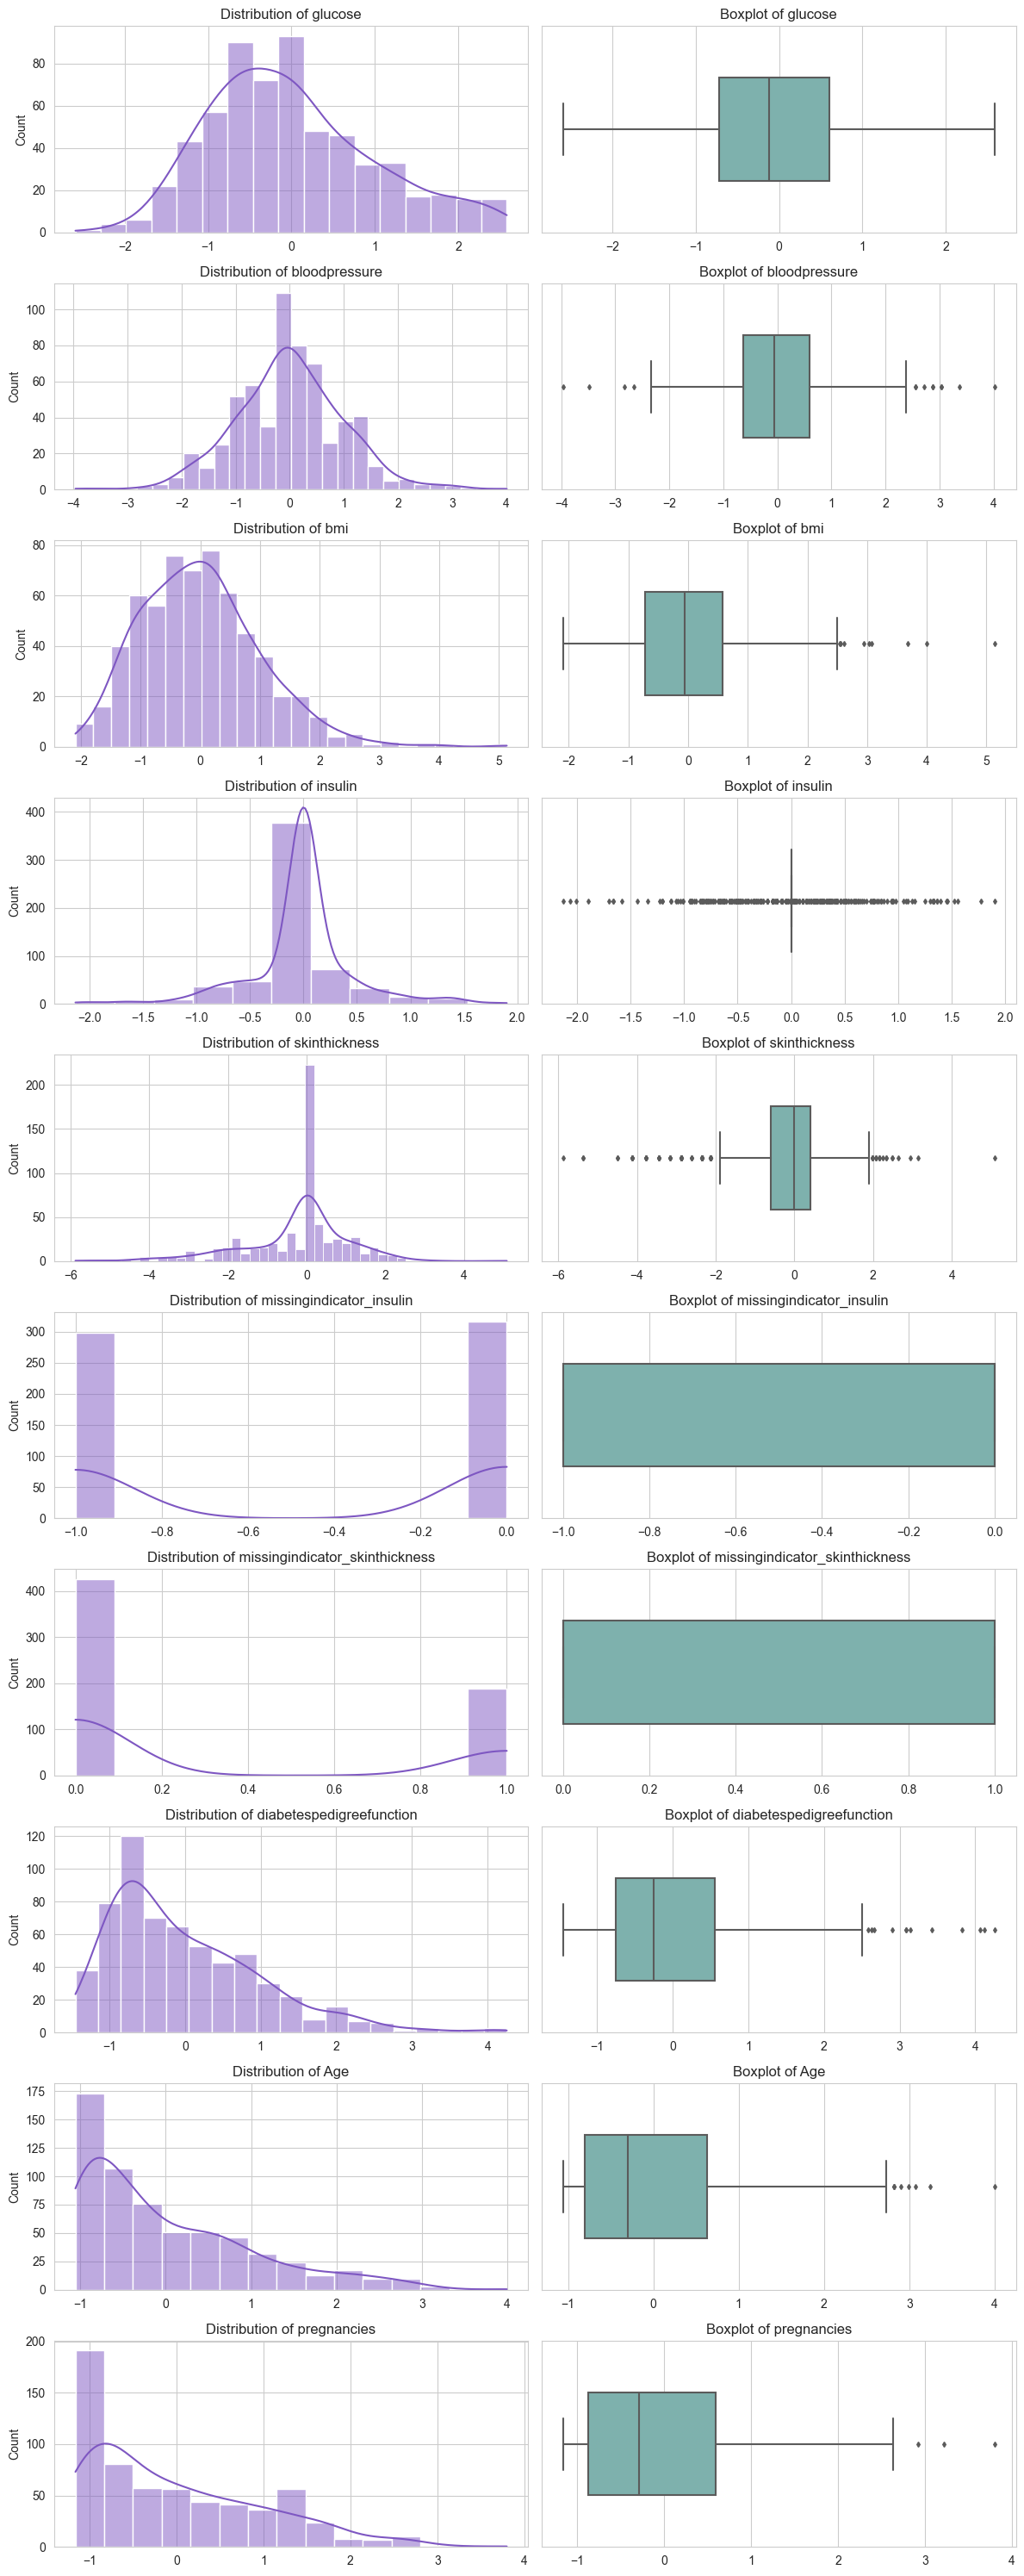

In [106]:


sns.set_style("whitegrid")

num_cols = X_train_linear_df.columns.tolist()

fig, axes = plt.subplots(len(num_cols), 2, figsize=(12, 3 * len(num_cols)))

for i, col in enumerate(num_cols):

    # Histogram + KDE plot
    sns.histplot(
        X_train_linear_df[col],
        kde=True,
        ax=axes[i, 0],
        color="#7E57C2"
    )
    axes[i, 0].set_title(f"Distribution of {col}")
    axes[i, 0].set_xlabel("")

    # Boxplot for outlier detection
    sns.boxplot(
        x=X_train_linear_df[col],
        ax=axes[i, 1],
        color="#75BAB4FF",
        width=0.5,
        fliersize=3
    )
    axes[i, 1].set_title(f"Boxplot of {col}")
    axes[i, 1].set_xlabel("")

plt.tight_layout()
plt.show()


**Observation**

After applying the preprocessing pipeline, all features are properly centered and scaled while preserving their original distribution patterns.  
Outlier influence is reduced through robust scaling rather than explicit removal, allowing potentially informative extreme clinical values to be retained. This indicates that the pipeline is functioning as intended without distorting the underlying data structure.

## 4. Modeling and Evaluation

### 4.0 Model 0 — Insulin Threshold Baseline (Rule-based)

A simple rule-based baseline was constructed using a single insulin threshold to quantify the standalone predictive signal contained in the insulin feature. Samples with zero insulin values were excluded, as these represent missing or unrecorded measurements.

This baseline is not intended as a production-ready classifier, but rather as a clinical intuition benchmark that provides a lower-bound reference for comparing learned machine learning models. It also highlights the limitation that insulin-based decision rules can only be applied to a subset of patients with valid insulin measurements.

Original test size: 154
Valid insulin test size: 96


,threshold,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,0.01,0.344,0.344,0.000,1.0,0.512,0.676,0.429
1,0.02,0.344,0.344,0.000,1.0,0.512,0.676,0.429
2,0.03,0.354,0.347,0.016,1.0,0.516,0.676,0.429
3,0.04,0.354,0.347,0.016,1.0,0.516,0.676,0.429
4,0.05,0.354,0.347,0.016,1.0,0.516,0.676,0.429


F1-optimal threshold: 0.130


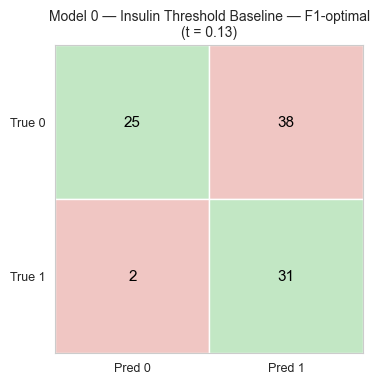

,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 0 — Insulin Threshold Baseline,0.5833,0.4493,0.3968,0.9394,0.6078,0.6763,0.4285


In [38]:
# ==========================================
# Model 0 — Insulin Threshold Baseline
# Rule-based clinical benchmark
# ==========================================

from sklearn.metrics import ConfusionMatrixDisplay
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
rows = []
threshold_model0 = []

rows = []
threshold_model0 = []

# Container to collect threshold-optimized results
threshold_results = []


# ==================================
# Step A — Use only valid insulin values (remove zeros)
# ==================================

mask_valid = X_test["insulin"] > 0

X_test_insulin_valid = X_test.loc[mask_valid]
y_test_insulin_valid = y_test.loc[mask_valid]

print("Original test size:", len(X_test))
print("Valid insulin test size:", len(X_test_insulin_valid))


# ==================================
# Step B — Build pseudo probability score
# (normalized insulin)
# ==================================

y_score_insulin = (
    X_test_insulin_valid["insulin"] /
    X_test_insulin_valid["insulin"].max()
)


# ============================================
# Threshold Optimization — Model 0
# ============================================

model_label = "Model 0 — Insulin Threshold Baseline"

# ---------------------
# Step C — Threshold sweep
# ---------------------

sweep_df = threshold_sweep(
    y_test_insulin_valid,
    y_score_insulin
)

display(sweep_df.round(3).head())


# ---------------------
# Step D — Select F1-optimal threshold
# ---------------------

t_f1, name_f1 = choose_threshold_by_objective(
    sweep_df,
    objective="f1_max"
)

print(f"F1-optimal threshold: {t_f1:.3f}")


# ---------------------
# Step E — Final evaluation at optimal threshold
# ---------------------

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

res_f1 = show_at_threshold(
    y_test_insulin_valid,
    y_score_insulin,
    t_f1,
    f"{model_label} — F1-optimal",
    ax=ax
)

plt.show()


# ==================================
# Build final predictions
# ==================================

y_pred_final = (y_score_insulin >= t_f1).astype(int)


# ==================================
# Store results (compatible with your global tables)
# ==================================

rows.append(
    metric_report(
        y_test_insulin_valid,
        y_pred_final,
        y_score_insulin,
        label=model_label
    )
)

threshold_model0.append({
    "model": model_label,
    "threshold": round(t_f1, 3),
    "accuracy": res_f1["accuracy"],
    "precision": res_f1["precision"],
    "recall": res_f1["recall"],
    "specificity": res_f1["specificity"],
    "f1": res_f1["f1"]
})

# ==========================================
# Compact comparison table
# ==========================================

df_model0_compare = pd.DataFrame(rows)
df_model0_threshold = pd.DataFrame(threshold_model0)

display(df_model0_compare.round(4))

### 4.1 Model 1 — Logistic Regression (Baseline)

This section evaluates logistic regression as the baseline classification model
for predicting diabetes outcome.

Three variants are considered:

* **Model 1a — Logistic Regression (no regularization)**
* **Model 1b — Logistic Regression with L2 regularization (cross-validated)**
* **Model 1c — Logistic Regression with L1 regularization (cross-validated)**

All models use the same preprocessing pipeline defined in Section 3.6.  
Given the presence of mild class imbalance, class weighting is applied to reduce
bias toward the majority class.

Model performance is evaluated on the held-out test set using a fixed decision
threshold of `t = 0.50`. Model comparison primarily relies on **ROC-AUC** to assess
overall ranking performance, while **PR-AUC** is additionally reported to better
reflect minority class detection performance. Standard classification metrics
(accuracy, precision, recall, and F1-score) are included for completeness.
Threshold optimization is addressed in a later section.


In [78]:
# ==========================================
# Model 1 — Logistic Regression (Baseline)
#   1a) Logistic (no regularization)
#   1b) Logistic + L2 (CV)
#   1c) Logistic + L1 (CV)
# ==========================================

rows_log = []

# ==================================
# 1a) Logistic — NO regularization
# ==================================

pipe_logit_plain = Pipeline(steps=[
    ("preprocessor", preprocessor_linear),
    ("classifier", LogisticRegression(
        C=1e6,                     # effectively no regularization
        solver="lbfgs",
        penalty="l2",
        class_weight="balanced",
        max_iter=3000,
        random_state=RANDOM_STATE
    ))
])

pipe_logit_plain.fit(X_train, y_train)

y_pred_1a  = pipe_logit_plain.predict(X_test)
y_proba_1a = pipe_logit_plain.predict_proba(X_test)[:, 1]

rows_log.append(
    metric_report(
        y_test,
        y_pred_1a,
        y_proba_1a,
        label="Model 1a — Logistic (No Reg)"
    )
)

# ==================================
# 1b) Logistic — L2 Regularization (CV)
# ==================================

pipe_logit_l2 = Pipeline(steps=[
    ("preprocessor", preprocessor_linear),
    ("classifier", LogisticRegressionCV(
        Cs=10,
        cv=5,
        solver="lbfgs",
        penalty="l2",
        scoring="roc_auc",
        class_weight="balanced",
        tol=1e-3,
        max_iter=5000,
        n_jobs=-1,
        random_state=RANDOM_STATE
    ))
])

pipe_logit_l2.fit(X_train, y_train)

y_pred_1b  = pipe_logit_l2.predict(X_test)
y_proba_1b = pipe_logit_l2.predict_proba(X_test)[:, 1]

best_c_l2 = pipe_logit_l2.named_steps["classifier"].C_[0]
print("\nBest C (L2):", round(best_c_l2, 4))

rows_log.append(
    metric_report(
        y_test,
        y_pred_1b,
        y_proba_1b,
        label="Model 1b — Logistic L2 (CV)"
    )
)

# ==================================
# 1c) Logistic — L1 Regularization (CV)
# ==================================

pipe_logit_l1 = Pipeline(steps=[
    ("preprocessor", preprocessor_linear),
    ("classifier", LogisticRegressionCV(
        Cs=10,
        cv=5,
        solver="saga",
        penalty="l1",
        scoring="roc_auc",
        class_weight="balanced",
        tol=1e-3,
        max_iter=5000,
        n_jobs=-1,
        random_state=RANDOM_STATE
    ))
])

pipe_logit_l1.fit(X_train, y_train)

y_pred_1c  = pipe_logit_l1.predict(X_test)
y_proba_1c = pipe_logit_l1.predict_proba(X_test)[:, 1]

best_c_l1 = pipe_logit_l1.named_steps["classifier"].C_[0]
print("Best C (L1):", round(best_c_l1, 4))

rows_log.append(
    metric_report(
        y_test,
        y_pred_1c,
        y_proba_1c,
        label="Model 1c — Logistic L1 (CV)"
    )
)

# ==========================================
# Comparison Table — Logistic Models
# ==========================================

df_model1_compare = pd.DataFrame(rows_log)
display(df_model1_compare.round(4))



Best C (L2): 0.3594
Best C (L1): 2.7826


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 1a — Logistic (No Reg),0.7857,0.6721,0.8,0.7593,0.713,0.8713,0.7711
1,Model 1b — Logistic L2 (CV),0.7857,0.6721,0.8,0.7593,0.713,0.8709,0.7706
2,Model 1c — Logistic L1 (CV),0.7857,0.6721,0.8,0.7593,0.713,0.8717,0.7719


,threshold,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,0.01,0.351,0.351,0.00,1.0,0.519,0.872,0.772
1,0.02,0.364,0.355,0.02,1.0,0.524,0.872,0.772
2,0.03,0.383,0.362,0.05,1.0,0.532,0.872,0.772
3,0.04,0.403,0.370,0.08,1.0,0.540,0.872,0.772
4,0.05,0.416,0.375,0.10,1.0,0.545,0.872,0.772


F1-optimal threshold: 0.40 (F1-max)
Precision≥0.70 threshold: 0.60 (precision≥0.7, max recall)
Recall≥0.70 threshold: 0.45 (recall≥0.7, max precision)


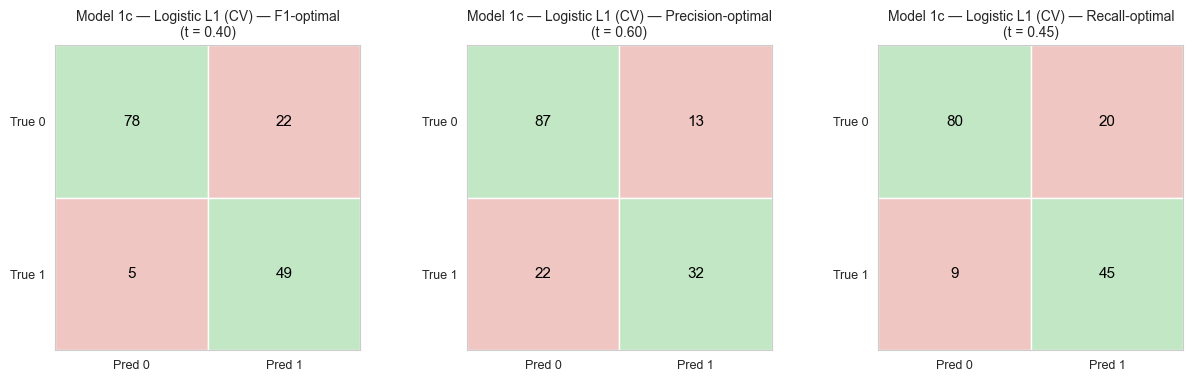


F1-optimal threshold metrics:


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 1c — Logistic L1 (CV) — F1-optimal (t=0.40),0.8247,0.6901,0.78,0.9074,0.784,0.8717,0.7719



Precision-optimal threshold metrics:


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 1c — Logistic L1 (CV) — Precision-optima...,0.7727,0.7111,0.87,0.5926,0.6465,0.8717,0.7719



Recall-optimal threshold metrics:


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 1c — Logistic L1 (CV) — Recall-optimal (...,0.8117,0.6923,0.8,0.8333,0.7563,0.8717,0.7719


In [79]:
# ============================================
# Threshold Optimization — Model 1c
# ============================================

# Select model for threshold optimization
y_proba_best = y_proba_1c
model_label  = "Model 1c — Logistic L1 (CV)"
# ----------------------------------

threshold_model1 = []

# ============================================
# Threshold Optimization
# ============================================

# ---------------------
# Step D — Threshold sweep
# ---------------------
sweep_df = threshold_sweep(y_test, y_proba_best)

# Display preview only (do NOT round real values)
display(sweep_df.round(3).head())


# ---------------------
# Step E — Select thresholds by objective
# ---------------------
t_f1, name_f1 = choose_threshold_by_objective(
    sweep_df, objective="f1_max"
)

t_prec, name_prec = choose_threshold_by_objective(
    sweep_df, objective="precision_at", target=0.70
)

t_rec, name_rec = choose_threshold_by_objective(
    sweep_df, objective="recall_at", target=0.70
)

print(f"F1-optimal threshold: {t_f1:.2f} ({name_f1})")
print(f"Precision≥0.70 threshold: {t_prec:.2f} ({name_prec})")
print(f"Recall≥0.70 threshold: {t_rec:.2f} ({name_rec})")


# ---------------------
# Step F — Evaluation at selected thresholds
# ---------------------
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

res_f1 = show_at_threshold(
    y_test, y_proba_best, t_f1,
    f"{model_label} — F1-optimal",
    ax=axes[0]
)

# ----------------------------------
# Store F1-optimal threshold result
# ----------------------------------

threshold_results.append({
    "model": model_label,
    "objective": "F1-optimal",
    "threshold": round(t_f1, 3),
    "accuracy": res_f1["accuracy"],
    "precision": res_f1["precision"],
    "recall": res_f1["recall"],
    "specificity": res_f1["specificity"],
    "f1": res_f1["f1"]
})

threshold_model1.append({
    "model": model_label,
    "threshold": round(t_f1, 3),

    "accuracy": res_f1["accuracy"],
    "precision": res_f1["precision"],
    "recall": res_f1["recall"],
    "specificity": res_f1["specificity"],
    "f1": res_f1["f1"]
})



res_prec = show_at_threshold(
    y_test, y_proba_best, t_prec,
    f"{model_label} — Precision-optimal",
    ax=axes[1]
)

res_rec = show_at_threshold(
    y_test, y_proba_best, t_rec,
    f"{model_label} — Recall-optimal",
    ax=axes[2]
)

#plt.tight_layout()

plt.subplots_adjust(
    left=0.06,
    right=1,
    wspace=0.35
)
plt.show()


# ---------------------
# Summary tables
# ---------------------
df_model1_threshold = pd.DataFrame(threshold_model1)

print("\nF1-optimal threshold metrics:")
display(pd.DataFrame([res_f1]).round(4))

print("\nPrecision-optimal threshold metrics:")
display(pd.DataFrame([res_prec]).round(4))

print("\nRecall-optimal threshold metrics:")
display(pd.DataFrame([res_rec]).round(4))

### 4.2 Model 2 — SGD-based Logistic Regression

In [41]:
# ==========================================
# Model 2 — SGD-based Logistic Regression
#   2a) SGD Logistic (no regularization)
#   2b) SGD Logistic + L2
#   2c) SGD Logistic + L1
# ==========================================

from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
import pandas as pd

rows_sgd = []

# ==================================
# 2a) SGD Logistic — NO regularization
# ==================================

pipe_sgd_plain = Pipeline(steps=[
    ("preprocessor", preprocessor_linear),
    ("classifier", SGDClassifier(
        loss="log_loss",          # logistic regression objective
        penalty=None,             # no regularization
        class_weight="balanced",  # handle mild class imbalance
        max_iter=3000,
        tol=1e-3,
        random_state=RANDOM_STATE
    ))
])

pipe_sgd_plain.fit(X_train, y_train)

y_pred_2a  = pipe_sgd_plain.predict(X_test)
y_proba_2a = pipe_sgd_plain.predict_proba(X_test)[:, 1]

rows_sgd.append(
    metric_report(
        y_test,
        y_pred_2a,
        y_proba_2a,
        label="Model 2a — SGD Logistic (No Reg)"
    )
)

# ==================================
# 2b) SGD Logistic — L2 Regularization
# ==================================

pipe_sgd_l2 = Pipeline(steps=[
    ("preprocessor", preprocessor_linear),
    ("classifier", SGDClassifier(
        loss="log_loss",
        penalty="l2",
        alpha=0.0001,             # regularization strength
        class_weight="balanced",
        max_iter=3000,
        tol=1e-3,
        random_state=RANDOM_STATE
    ))
])

pipe_sgd_l2.fit(X_train, y_train)

y_pred_2b  = pipe_sgd_l2.predict(X_test)
y_proba_2b = pipe_sgd_l2.predict_proba(X_test)[:, 1]

rows_sgd.append(
    metric_report(
        y_test,
        y_pred_2b,
        y_proba_2b,
        label="Model 2b — SGD Logistic L2"
    )
)

# ==================================
# 2c) SGD Logistic — L1 Regularization
# ==================================

pipe_sgd_l1 = Pipeline(steps=[
    ("preprocessor", preprocessor_linear),
    ("classifier", SGDClassifier(
        loss="log_loss",
        penalty="l1",
        alpha=0.0001,
        class_weight="balanced",
        max_iter=3000,
        tol=1e-3,
        random_state=RANDOM_STATE
    ))
])

pipe_sgd_l1.fit(X_train, y_train)

y_pred_2c  = pipe_sgd_l1.predict(X_test)
y_proba_2c = pipe_sgd_l1.predict_proba(X_test)[:, 1]

rows_sgd.append(
    metric_report(
        y_test,
        y_pred_2c,
        y_proba_2c,
        label="Model 2c — SGD Logistic L1"
    )
)

# ==========================================
# Comparison Table — SGD Models
# ==========================================

df_model2_compare = pd.DataFrame(rows_sgd)
display(df_model2_compare.round(4))


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 2a — SGD Logistic (No Reg),0.7532,0.6250,0.76,0.7407,0.6780,0.8541,0.7547
1,Model 2b — SGD Logistic L2,0.7532,0.6250,0.76,0.7407,0.6780,0.8541,0.7547
2,Model 2c — SGD Logistic L1,0.7857,0.7143,0.86,0.6481,0.6796,0.8733,0.7687


,threshold,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,0.01,0.448,0.388,0.15,1.000,0.560,0.873,0.769
1,0.02,0.500,0.412,0.23,1.000,0.584,0.873,0.769
2,0.03,0.591,0.462,0.37,1.000,0.632,0.873,0.769
3,0.04,0.610,0.473,0.41,0.981,0.639,0.873,0.769
4,0.05,0.610,0.473,0.42,0.963,0.634,0.873,0.769


F1-optimal threshold: 0.17 (F1-max)
Precision≥0.70 threshold: 0.38 (precision≥0.7, max recall)
Recall≥0.70 threshold: 0.39 (recall≥0.7, max precision)


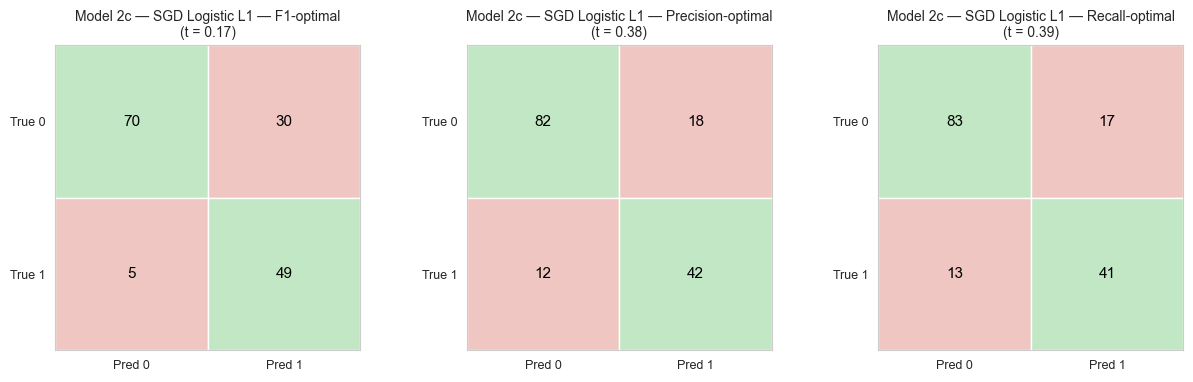


F1-optimal threshold metrics:


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 2c — SGD Logistic L1 — F1-optimal (t=0.17),0.7727,0.6203,0.7,0.9074,0.7368,0.8733,0.7687



Precision-optimal threshold metrics:


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 2c — SGD Logistic L1 — Precision-optimal...,0.8052,0.7,0.82,0.7778,0.7368,0.8733,0.7687



Recall-optimal threshold metrics:


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 2c — SGD Logistic L1 — Recall-optimal (t...,0.8052,0.7069,0.83,0.7593,0.7321,0.8733,0.7687


In [42]:
# ============================================
# Threshold Optimization — Model 2c
# ============================================

threshold_model2 = []

# Select model for threshold optimization
y_proba_best = y_proba_2c
model_label  = "Model 2c — SGD Logistic L1"
# ----------------------------------


# ============================================
# Threshold Optimization
# ============================================

# ---------------------
# Step D — Threshold sweep
# ---------------------
sweep_df = threshold_sweep(y_test, y_proba_best)

# Display preview only (do NOT round real values)
display(sweep_df.round(3).head())


# ---------------------
# Step E — Select thresholds by objective
# ---------------------
t_f1, name_f1 = choose_threshold_by_objective(
    sweep_df, objective="f1_max"
)

t_prec, name_prec = choose_threshold_by_objective(
    sweep_df, objective="precision_at", target=0.70
)

t_rec, name_rec = choose_threshold_by_objective(
    sweep_df, objective="recall_at", target=0.70
)

print(f"F1-optimal threshold: {t_f1:.2f} ({name_f1})")
print(f"Precision≥0.70 threshold: {t_prec:.2f} ({name_prec})")
print(f"Recall≥0.70 threshold: {t_rec:.2f} ({name_rec})")


# ---------------------
# Step F — Evaluation at selected thresholds
# ---------------------
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

res_f1 = show_at_threshold(
    y_test, y_proba_best, t_f1,
    f"{model_label} — F1-optimal",
    ax=axes[0]
)
# ----------------------------------
# Store F1-optimal threshold result
# ----------------------------------

threshold_results.append({
    "model": model_label,
    "objective": "F1-optimal",
    "threshold": round(t_f1, 3),
    "accuracy": res_f1["accuracy"],
    "precision": res_f1["precision"],
    "recall": res_f1["recall"],
    "specificity": res_f1["specificity"],
    "f1": res_f1["f1"]
})

threshold_model2.append({
    "model": model_label,
    "threshold": round(t_f1, 3),

    "accuracy": res_f1["accuracy"],
    "precision": res_f1["precision"],
    "recall": res_f1["recall"],
    "specificity": res_f1["specificity"],
    "f1": res_f1["f1"]
})



res_prec = show_at_threshold(
    y_test, y_proba_best, t_prec,
    f"{model_label} — Precision-optimal",
    ax=axes[1]
)

res_rec = show_at_threshold(
    y_test, y_proba_best, t_rec,
    f"{model_label} — Recall-optimal",
    ax=axes[2]
)

#plt.tight_layout()

plt.subplots_adjust(
    left=0.06,
    right=1,
    wspace=0.35
)
plt.show()


# ---------------------
# Summary tables
# ---------------------
df_model2_threshold = pd.DataFrame(threshold_model2)

print("\nF1-optimal threshold metrics:")
display(pd.DataFrame([res_f1]).round(4))

print("\nPrecision-optimal threshold metrics:")
display(pd.DataFrame([res_prec]).round(4))

print("\nRecall-optimal threshold metrics:")
display(pd.DataFrame([res_rec]).round(4))


### 4.3 Model 3 — Support Vector Machines with Cross-Validation

This section evaluates Support Vector Machine (SVM) classifiers as margin-based alternatives to logistic regression for predicting diabetes outcome.

Two variants are considered:

* **Model 3a — Linear SVC**
* **Model 3b — SVC with RBF kernel**

All models use the same preprocessing pipeline defined in Section 3.6 and handle class imbalance using class weighting.
Model selection is performed via cross-validation using **ROC-AUC** as the primary optimization metric. Final evaluation is conducted on the held-out test set using a fixed decision threshold of `t = 0.50`. In addition to ROC-AUC, **PR-AUC** is reported to better assess minority class detection performance. Probability estimates are enabled to support threshold optimization in later stages.


In [101]:
# ==========================================
# Model 3 — Support Vector Machines (CV + Calibration)
#   3a) Linear SVC (CV on C + Calibrated)
#   3b) RBF SVC (CV on C and gamma + Calibrated)
# ==========================================

rows_svc = []


# ==================================
# 3a) Linear SVC — CV on C + Calibration
# ==================================

pipe_svc_linear = Pipeline(steps=[
    ("preprocessor", preprocessor_linear),
    ("classifier", SVC(
        kernel="linear",
        probability=True,
        class_weight="balanced",
        random_state=RANDOM_STATE
    ))
])

param_grid_linear = {
    "classifier__C": [0.01, 0.1, 1, 10, 100]
}

grid_svc_linear = GridSearchCV(
    pipe_svc_linear,
    param_grid=param_grid_linear,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1
)

grid_svc_linear.fit(X_train, y_train)

best_linear_model = grid_svc_linear.best_estimator_
best_c_linear = grid_svc_linear.best_params_["classifier__C"]

print("\nBest C (Linear SVC):", best_c_linear)


# -------- Calibration --------

calibrated_linear = CalibratedClassifierCV(
    best_linear_model,
    method="sigmoid",   # Platt scaling
    cv=5
)

calibrated_linear.fit(X_train, y_train)


# -------- Evaluation --------

y_pred_3a  = calibrated_linear.predict(X_test)
y_proba_3a = calibrated_linear.predict_proba(X_test)[:, 1]

rows_svc.append(
    metric_report(
        y_test,
        y_pred_3a,
        y_proba_3a,
        label="Model 3a — Linear SVC (CV + Calibration)"
    )
)


# ==================================
# 3b) RBF SVC — CV on C & gamma + Calibration
# ==================================

pipe_svc_rbf = Pipeline(steps=[
    ("preprocessor", preprocessor_linear),
    ("classifier", SVC(
        kernel="rbf",
        probability=True,
        class_weight="balanced",
        random_state=RANDOM_STATE
    ))
])

param_grid_rbf = {
    "classifier__C": [0.1, 1, 10, 100],
    "classifier__gamma": ["scale", 0.1, 0.01, 0.001, 0.0001]
}

grid_svc_rbf = GridSearchCV(
    pipe_svc_rbf,
    param_grid=param_grid_rbf,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1
)

grid_svc_rbf.fit(X_train, y_train)

best_rbf_model = grid_svc_rbf.best_estimator_

best_c_rbf     = grid_svc_rbf.best_params_["classifier__C"]
best_gamma_rbf = grid_svc_rbf.best_params_["classifier__gamma"]

print("Best C (RBF SVC):", best_c_rbf)
print("Best gamma (RBF SVC):", best_gamma_rbf)


# -------- Calibration --------

calibrated_rbf = CalibratedClassifierCV(
    best_rbf_model,
    method="sigmoid",
    cv=5
)

calibrated_rbf.fit(X_train, y_train)


# -------- Evaluation --------

y_pred_3b  = calibrated_rbf.predict(X_test)
y_proba_3b = calibrated_rbf.predict_proba(X_test)[:, 1]

rows_svc.append(
    metric_report(
        y_test,
        y_pred_3b,
        y_proba_3b,
        label="Model 3b — RBF SVC (CV + Calibration)"
    )
)


# ==========================================
# Comparison Table — SVM Models
# ==========================================

df_model3_compare = pd.DataFrame(rows_svc)
display(df_model3_compare.round(4))



Best C (Linear SVC): 0.1
Best C (RBF SVC): 1
Best gamma (RBF SVC): 0.01


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 3a — Linear SVC (CV + Calibration),0.7597,0.7179,0.89,0.5185,0.6022,0.8659,0.7605
1,Model 3b — RBF SVC (CV + Calibration),0.7727,0.7209,0.88,0.5741,0.6392,0.8635,0.7755


,threshold,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,0.01,0.351,0.351,0.00,1.0,0.519,0.864,0.776
1,0.02,0.357,0.353,0.01,1.0,0.522,0.864,0.776
2,0.03,0.383,0.362,0.05,1.0,0.532,0.864,0.776
3,0.04,0.403,0.370,0.08,1.0,0.540,0.864,0.776
4,0.05,0.448,0.388,0.15,1.0,0.560,0.864,0.776


F1-optimal threshold: 0.27 (F1-max)
Precision≥0.70 threshold: 0.48 (precision≥0.7, max recall)
Recall≥0.70 threshold: 0.36 (recall≥0.7, max precision)


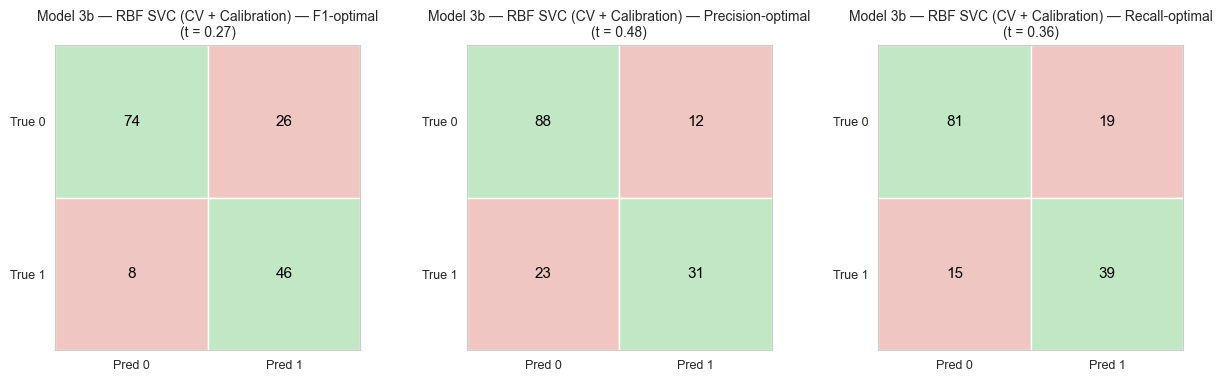


F1-optimal threshold metrics:


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 3b — RBF SVC (CV + Calibration) — F1-opt...,0.7792,0.6389,0.74,0.8519,0.7302,0.8635,0.7755



Precision-optimal threshold metrics:


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 3b — RBF SVC (CV + Calibration) — Precis...,0.7727,0.7209,0.88,0.5741,0.6392,0.8635,0.7755



Recall-optimal threshold metrics:


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 3b — RBF SVC (CV + Calibration) — Recall...,0.7792,0.6724,0.81,0.7222,0.6964,0.8635,0.7755


In [100]:
# ============================================
# Threshold Optimization — Model 3b
# ============================================

threshold_model3 = []

# Select model for threshold optimization
y_proba_best = y_proba_3b
model_label  = "Model 3b — RBF SVC (CV + Calibration)"
# ----------------------------------


# ============================================
# Threshold Optimization
# ============================================

# ---------------------
# Step D — Threshold sweep
# ---------------------
sweep_df = threshold_sweep(y_test, y_proba_best)

# Display preview only (do NOT round real values)
display(sweep_df.round(3).head())


# ---------------------
# Step E — Select thresholds by objective
# ---------------------
t_f1, name_f1 = choose_threshold_by_objective(
    sweep_df, objective="f1_max"
)

t_prec, name_prec = choose_threshold_by_objective(
    sweep_df, objective="precision_at", target=0.70
)

t_rec, name_rec = choose_threshold_by_objective(
    sweep_df, objective="recall_at", target=0.70
)

print(f"F1-optimal threshold: {t_f1:.2f} ({name_f1})")
print(f"Precision≥0.70 threshold: {t_prec:.2f} ({name_prec})")
print(f"Recall≥0.70 threshold: {t_rec:.2f} ({name_rec})")


# ---------------------
# Step F — Evaluation at selected thresholds
# ---------------------
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

res_f1 = show_at_threshold(
    y_test, y_proba_best, t_f1,
    f"{model_label} — F1-optimal",
    ax=axes[0]
)

# ----------------------------------
# Store F1-optimal threshold result
# ----------------------------------

threshold_results.append({
    "model": model_label,
    "objective": "F1-optimal",
    "threshold": round(t_f1, 3),
    "accuracy": res_f1["accuracy"],
    "precision": res_f1["precision"],
    "recall": res_f1["recall"],
    "specificity": res_f1["specificity"],
    "f1": res_f1["f1"]
})

threshold_model3.append({
    "model": model_label,
    "threshold": round(t_f1, 3),

    "accuracy": res_f1["accuracy"],
    "precision": res_f1["precision"],
    "recall": res_f1["recall"],
    "specificity": res_f1["specificity"],
    "f1": res_f1["f1"]
})



res_prec = show_at_threshold(
    y_test, y_proba_best, t_prec,
    f"{model_label} — Precision-optimal",
    ax=axes[1]
)

res_rec = show_at_threshold(
    y_test, y_proba_best, t_rec,
    f"{model_label} — Recall-optimal",
    ax=axes[2]
)

#plt.tight_layout()

plt.subplots_adjust(
    left=0.06,
    right=1,
    wspace=0.35
)
plt.show()

# ---------------------
# Summary tables
# ---------------------

df_model3_threshold = pd.DataFrame(threshold_model3)

print("\nF1-optimal threshold metrics:")
display(pd.DataFrame([res_f1]).round(4))

print("\nPrecision-optimal threshold metrics:")
display(pd.DataFrame([res_prec]).round(4))

print("\nRecall-optimal threshold metrics:")
display(pd.DataFrame([res_rec]).round(4))


### 4.4 Model 4 — K-Nearest Neighbors (k Optimized via Cross-Validation + + Calibrated)

In [99]:
# ==========================================
# Model 4 — KNN (k optimized with CV + Calibration)
# ==========================================

rows_knn = []

# ==================================
# Pipeline definition (scaled features required)
# ==================================

pipe_knn = Pipeline(steps=[
    ("preprocessor", preprocessor_linear),   # distance-based -> scaling required
    ("classifier", KNeighborsClassifier())
])

# ==================================
# Hyperparameter grid (k values)
# ==================================

param_grid_knn = {
    "classifier__n_neighbors": [3, 5, 7, 9, 11, 15],
    "classifier__weights": ["uniform", "distance"]
}

# ==================================
# GridSearchCV
# ==================================

grid_knn = GridSearchCV(
    pipe_knn,
    param_grid=param_grid_knn,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1
)

grid_knn.fit(X_train, y_train)

# ==================================
# Best model & hyperparameters
# ==================================

best_knn_model = grid_knn.best_estimator_

best_k = grid_knn.best_params_["classifier__n_neighbors"]
best_weight = grid_knn.best_params_["classifier__weights"]

print("\nBest k (KNN):", best_k)
print("Best weighting scheme:", best_weight)

# -------- Calibration --------

calibrated_knn = CalibratedClassifierCV(
    estimator=best_knn_model,
    method="isotonic",
    cv=5
)

calibrated_knn.fit(X_train, y_train)

# ==================================
# Evaluation on test set
# ==================================

y_pred_4  = calibrated_knn.predict(X_test)
y_proba_4 = calibrated_knn.predict_proba(X_test)[:,1]

rows_knn.append(
    metric_report(
        y_test,
        y_pred_4,
        y_proba_4,
        label="Model 4 — KNN (CV Optimized + Calibration)"
    )
)

# ==========================================
# Comparison Table — KNN
# ==========================================

df_model4_compare = pd.DataFrame(rows_knn)
display(df_model4_compare.round(4))



Best k (KNN): 15
Best weighting scheme: uniform


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 4 — KNN (CV Optimized + Calibration),0.7662,0.7368,0.9,0.5185,0.6087,0.832,0.7479


,threshold,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,0.01,0.351,0.351,0.00,1.0,0.519,0.832,0.748
1,0.02,0.351,0.351,0.00,1.0,0.519,0.832,0.748
2,0.03,0.351,0.351,0.00,1.0,0.519,0.832,0.748
3,0.04,0.351,0.351,0.00,1.0,0.519,0.832,0.748
4,0.05,0.442,0.386,0.14,1.0,0.557,0.832,0.748


F1-optimal threshold: 0.26 (F1-max)
Precision≥0.70 threshold: 0.44 (precision≥0.7, max recall)
Recall≥0.70 threshold: 0.33 (recall≥0.7, max precision)


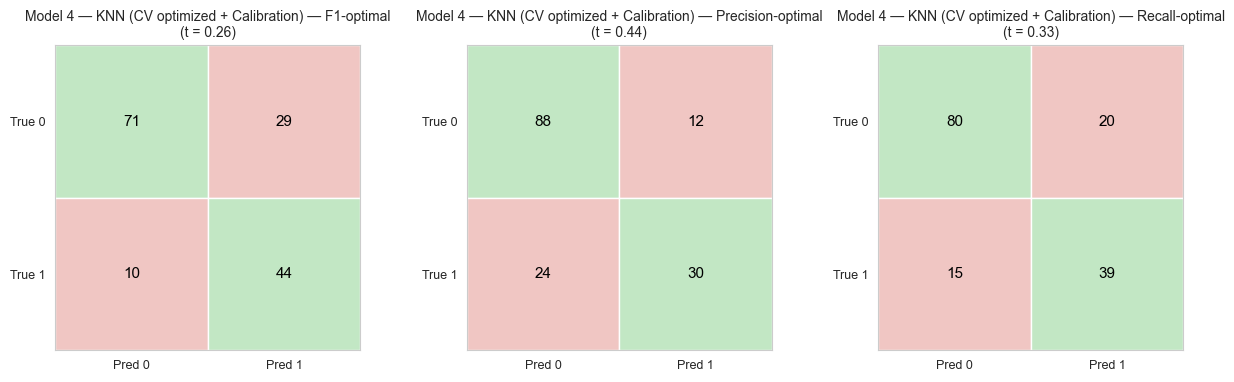


F1-optimal threshold metrics:


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 4 — KNN (CV optimized + Calibration) — F...,0.7468,0.6027,0.71,0.8148,0.6929,0.832,0.7479



Precision-optimal threshold metrics:


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 4 — KNN (CV optimized + Calibration) — P...,0.7662,0.7143,0.88,0.5556,0.625,0.832,0.7479



Recall-optimal threshold metrics:


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 4 — KNN (CV optimized + Calibration) — R...,0.7727,0.661,0.8,0.7222,0.6903,0.832,0.7479


In [104]:
# ============================================
# Threshold Optimization — Model 4 — KNN (CV optimized + Calibration)
# ============================================

threshold_model4 = []

# Select model for threshold optimization
y_proba_best = y_proba_4
model_label  = "Model 4 — KNN (CV optimized + Calibration)"
# ----------------------------------


# ============================================
# Threshold Optimization
# ============================================

# ---------------------
# Step D — Threshold sweep
# ---------------------
sweep_df = threshold_sweep(y_test, y_proba_best)

# Display preview only (do NOT round real values)
display(sweep_df.round(3).head())


# ---------------------
# Step E — Select thresholds by objective
# ---------------------
t_f1, name_f1 = choose_threshold_by_objective(
    sweep_df, objective="f1_max"
)

t_prec, name_prec = choose_threshold_by_objective(
    sweep_df, objective="precision_at", target=0.70
)

t_rec, name_rec = choose_threshold_by_objective(
    sweep_df, objective="recall_at", target=0.70
)

print(f"F1-optimal threshold: {t_f1:.2f} ({name_f1})")
print(f"Precision≥0.70 threshold: {t_prec:.2f} ({name_prec})")
print(f"Recall≥0.70 threshold: {t_rec:.2f} ({name_rec})")


# ---------------------
# Step F — Evaluation at selected thresholds
# ---------------------
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

res_f1 = show_at_threshold(
    y_test, y_proba_best, t_f1,
    f"{model_label} — F1-optimal",
    ax=axes[0]
)

# ----------------------------------
# Store F1-optimal threshold result
# ----------------------------------

threshold_results.append({
    "model": model_label,
    "objective": "F1-optimal",
    "threshold": round(t_f1, 3),
    "accuracy": res_f1["accuracy"],
    "precision": res_f1["precision"],
    "recall": res_f1["recall"],
    "specificity": res_f1["specificity"],
    "f1": res_f1["f1"]
})

threshold_model4.append({
    "model": model_label,
    "threshold": round(t_f1, 3),

    "accuracy": res_f1["accuracy"],
    "precision": res_f1["precision"],
    "recall": res_f1["recall"],
    "specificity": res_f1["specificity"],
    "f1": res_f1["f1"]
})


res_prec = show_at_threshold(
    y_test, y_proba_best, t_prec,
    f"{model_label} — Precision-optimal",
    ax=axes[1]
)

res_rec = show_at_threshold(
    y_test, y_proba_best, t_rec,
    f"{model_label} — Recall-optimal",
    ax=axes[2]
)

#plt.tight_layout()

plt.subplots_adjust(
    left=0.06,
    right=1,
    wspace=0.35
)
plt.show()


# ---------------------
# Summary tables
# ---------------------
df_model4_threshold = pd.DataFrame(threshold_model4)

print("\nF1-optimal threshold metrics:")
display(pd.DataFrame([res_f1]).round(4))

print("\nPrecision-optimal threshold metrics:")
display(pd.DataFrame([res_prec]).round(4))

print("\nRecall-optimal threshold metrics:")
display(pd.DataFrame([res_rec]).round(4))


### 4.5 Model 5 — Polynomial Logistic Regression

This section evaluates polynomial logistic regression models to capture non-linear relationships between input features and the diabetes outcome while preserving the interpretability of linear classifiers.

Three variants are considered:

* **Model 5a — Polynomial Logistic Regression (no regularization)**
* **Model 5b — Polynomial Logistic Regression with L2 regularization (cross-validated)**
* **Model 5c — Polynomial Logistic Regression with L1 regularization (cross-validated)**

All models use the polynomial preprocessing pipeline defined in Section 3.6.
Class imbalance is handled using class weighting. Model performance is evaluated on the held-out test set using a fixed decision threshold of `t = 0.50`. Model selection primarily relies on **ROC-AUC**, while **PR-AUC** is additionally reported to assess minority class detection performance. Threshold optimization is addressed in a later section.


In [70]:
# ==========================================
# Model 5 — Polynomial Logistic Regression
#   5a) Polynomial Logistic (no regularization)
#   5b) Polynomial Logistic + L2 (CV)
#   5c) Polynomial Logistic + L1 (CV)
# ==========================================

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import pandas as pd

rows_poly = []

# ==================================
# 5a) Polynomial Logistic — NO regularization
# ==================================

pipe_poly_plain = Pipeline(steps=[
    ("preprocessor", preprocessor_poly),
    ("classifier", LogisticRegression(
        C=1e6,                     # effectively no regularization
        solver="lbfgs",
        class_weight="balanced",
        max_iter=5000,
        random_state=RANDOM_STATE
    ))
])

pipe_poly_plain.fit(X_train, y_train)

y_pred_5a  = pipe_poly_plain.predict(X_test)
y_proba_5a = pipe_poly_plain.predict_proba(X_test)[:, 1]

rows_poly.append(
    metric_report(
        y_test,
        y_pred_5a,
        y_proba_5a,
        label="Model 5a — Polynomial Logistic (No Reg)"
    )
)

# ==================================
# 5b) Polynomial Logistic — L2 Regularization (CV)
# ==================================

pipe_poly_l2 = Pipeline(steps=[
    ("preprocessor", preprocessor_poly),
    ("classifier", LogisticRegressionCV(
        penalty="l2",
        Cs=10,
        cv=5,
        solver="lbfgs",
        scoring="roc_auc",
        class_weight="balanced",
        tol=1e-3,
        max_iter=5000,
        n_jobs=-1,
        random_state=RANDOM_STATE
    ))
])

pipe_poly_l2.fit(X_train, y_train)

y_pred_5b  = pipe_poly_l2.predict(X_test)
y_proba_5b = pipe_poly_l2.predict_proba(X_test)[:, 1]

best_c_poly_l2 = pipe_poly_l2.named_steps["classifier"].C_[0]
print("\nBest C (Polynomial L2):", best_c_poly_l2.round(4))

rows_poly.append(
    metric_report(
        y_test,
        y_pred_5b,
        y_proba_5b,
        label="Model 5b — Polynomial Logistic L2 (CV)"
    )
)

# ==================================
# 5c) Polynomial Logistic — L1 Regularization (CV)
# ==================================

pipe_poly_l1 = Pipeline(steps=[
    ("preprocessor", preprocessor_poly),
    ("classifier", LogisticRegressionCV(
        penalty="l1",
        Cs=10,
        cv=5,
        solver="saga",             # required for L1
        scoring="roc_auc",
        class_weight="balanced",
        tol=1e-3,
        max_iter=5000,
        n_jobs=-1,
        random_state=RANDOM_STATE
    ))
])

pipe_poly_l1.fit(X_train, y_train)

y_pred_5c  = pipe_poly_l1.predict(X_test)
y_proba_5c = pipe_poly_l1.predict_proba(X_test)[:, 1]

best_c_poly_l1 = pipe_poly_l1.named_steps["classifier"].C_[0]
print("Best C (Polynomial L1):", best_c_poly_l1.round(4))

rows_poly.append(
    metric_report(
        y_test,
        y_pred_5c,
        y_proba_5c,
        label="Model 5c — Polynomial Logistic L1 (CV)"
    )
)

# ==========================================
# Comparison Table — Polynomial Logistic Models
# ==========================================

df_model5_compare = pd.DataFrame(rows_poly)
display(df_model5_compare.round(4))



Best C (Polynomial L2): 0.3594
Best C (Polynomial L1): 0.3594


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 5a — Polynomial Logistic (No Reg),0.7922,0.6719,0.79,0.7963,0.7288,0.8548,0.7661
1,Model 5b — Polynomial Logistic L2 (CV),0.7857,0.6721,0.80,0.7593,0.7130,0.8678,0.7742
2,Model 5c — Polynomial Logistic L1 (CV),0.7662,0.6552,0.80,0.7037,0.6786,0.8685,0.7593


,threshold,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,0.01,0.351,0.351,0.00,1.0,0.519,0.868,0.774
1,0.02,0.357,0.353,0.01,1.0,0.522,0.868,0.774
2,0.03,0.383,0.362,0.05,1.0,0.532,0.868,0.774
3,0.04,0.403,0.370,0.08,1.0,0.540,0.868,0.774
4,0.05,0.409,0.372,0.09,1.0,0.543,0.868,0.774


F1-optimal threshold: 0.38 (F1-max)
Precision≥0.70 threshold: 0.60 (precision≥0.7, max recall)
Recall≥0.70 threshold: 0.47 (recall≥0.7, max precision)


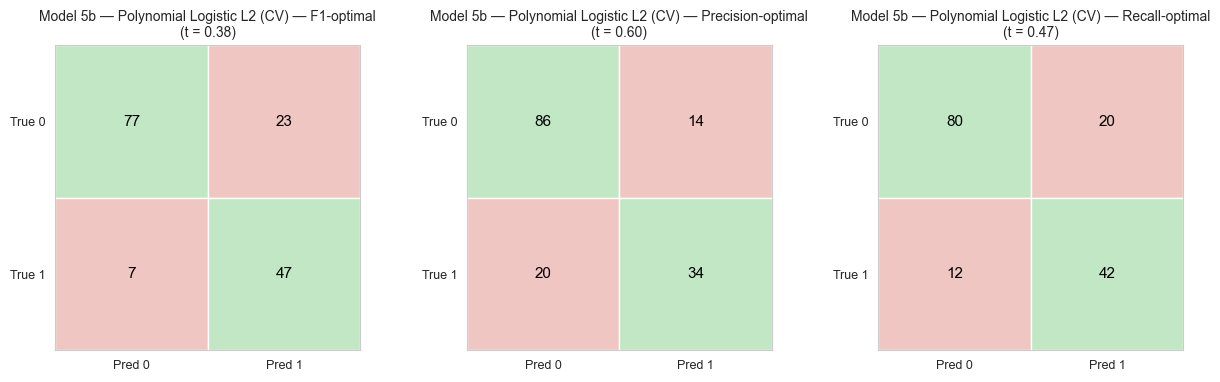


F1-optimal threshold metrics:


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 5b — Polynomial Logistic L2 (CV) — F1-op...,0.8052,0.6714,0.77,0.8704,0.7581,0.8678,0.7742



Precision-optimal threshold metrics:


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 5b — Polynomial Logistic L2 (CV) — Preci...,0.7792,0.7083,0.86,0.6296,0.6667,0.8678,0.7742



Recall-optimal threshold metrics:


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 5b — Polynomial Logistic L2 (CV) — Recal...,0.7922,0.6774,0.8,0.7778,0.7241,0.8678,0.7742


In [71]:
# ============================================
# Threshold Optimization — Model 5b
# ============================================

threshold_model5 = []

# Select model for threshold optimization
y_proba_best = y_proba_5b
model_label  = "Model 5b — Polynomial Logistic L2 (CV)"
# ----------------------------------


# ============================================
# Threshold Optimization
# ============================================

# ---------------------
# Step D — Threshold sweep
# ---------------------
sweep_df = threshold_sweep(y_test, y_proba_best)

# Display preview only (do NOT round real values)
display(sweep_df.round(3).head())


# ---------------------
# Step E — Select thresholds by objective
# ---------------------
t_f1, name_f1 = choose_threshold_by_objective(
    sweep_df, objective="f1_max"
)

t_prec, name_prec = choose_threshold_by_objective(
    sweep_df, objective="precision_at", target=0.70
)

t_rec, name_rec = choose_threshold_by_objective(
    sweep_df, objective="recall_at", target=0.70
)

print(f"F1-optimal threshold: {t_f1:.2f} ({name_f1})")
print(f"Precision≥0.70 threshold: {t_prec:.2f} ({name_prec})")
print(f"Recall≥0.70 threshold: {t_rec:.2f} ({name_rec})")


# ---------------------
# Step F — Evaluation at selected thresholds
# ---------------------
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

res_f1 = show_at_threshold(
    y_test, y_proba_best, t_f1,
    f"{model_label} — F1-optimal",
    ax=axes[0]
)

# ----------------------------------
# Store F1-optimal threshold result
# ----------------------------------

threshold_results.append({
    "model": model_label,
    "objective": "F1-optimal",
    "threshold": round(t_f1, 3),
    "accuracy": res_f1["accuracy"],
    "precision": res_f1["precision"],
    "recall": res_f1["recall"],
    "specificity": res_f1["specificity"],
    "f1": res_f1["f1"]
})

threshold_model5.append({
    "model": model_label,
    "threshold": round(t_f1, 3),

    "accuracy": res_f1["accuracy"],
    "precision": res_f1["precision"],
    "recall": res_f1["recall"],
    "specificity": res_f1["specificity"],
    "f1": res_f1["f1"]
})


res_prec = show_at_threshold(
    y_test, y_proba_best, t_prec,
    f"{model_label} — Precision-optimal",
    ax=axes[1]
)

res_rec = show_at_threshold(
    y_test, y_proba_best, t_rec,
    f"{model_label} — Recall-optimal",
    ax=axes[2]
)

plt.subplots_adjust(
    left=0.06,
    right=1,
    wspace=0.35
)
plt.show()


# ---------------------
# Summary tables
# ---------------------

df_model5_threshold = pd.DataFrame(threshold_model5)

print("\nF1-optimal threshold metrics:")
display(pd.DataFrame([res_f1]).round(4))

print("\nPrecision-optimal threshold metrics:")
display(pd.DataFrame([res_prec]).round(4))

print("\nRecall-optimal threshold metrics:")
display(pd.DataFrame([res_rec]).round(4))


### 4.6 Model 6 — Decision Trees

This section evaluates decision tree classifiers to capture non-linear relationships and feature interactions in the diabetes prediction task.

Three variants are considered:

* **Model 56 — Fully grown tree (no tuning)**
* **Model 56 — Hyperparameter-tuned tree (cross-validated)**
* **Model 56 — Cost-complexity pruned tree (CCP)**

All models use the tree-specific preprocessing pipeline defined in Section 3.6 and handle class imbalance using class weighting. Model evaluation is performed on the held-out test set using a fixed decision threshold of `t = 0.50`, prior to threshold optimization.


In [96]:
# ==========================================
# Model 6 — Decision Trees (balanced)
#   6a) Full tree (no tuning)
#   6b) Tuned tree (CV)
#   6c) Pruned tree (CCP)
# ==========================================

from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import pandas as pd

rows_tree = []

# ==================================
# 6a) Full Decision Tree (baseline)
# ==================================

pipe_tree_full = Pipeline(steps=[
    ("preprocessor", preprocessor_tree),
    ("classifier", DecisionTreeClassifier(
        class_weight="balanced",
        random_state=RANDOM_STATE
    ))
])

pipe_tree_full.fit(X_train, y_train)

# -------- Calibration --------
# ==================================

calibrated_tree_6a = CalibratedClassifierCV(
    estimator=pipe_tree_full,
    method="sigmoid",   # stable choice
    cv=5
)

calibrated_tree_6a.fit(X_train, y_train)

# ==================================
# Evaluation on test set
# ==================================

y_pred_6a  = calibrated_tree_6a.predict(X_test)
y_proba_6a = calibrated_tree_6a.predict_proba(X_test)[:, 1]

rows_tree.append(
    metric_report(
        y_test,
        y_pred_6a,
        y_proba_6a,
        label="Model 6a — Decision Tree (Full + Calibration)"
    )
)

# ==================================
# 6b) Tuned Decision Tree (CV)
# ==================================

param_grid_tree = {
    "classifier__max_depth": [3, 5, 8, 12, None],
    "classifier__min_samples_split": [2, 10, 50],
    "classifier__min_samples_leaf": [1, 5, 20]
}

pipe_tree_base = Pipeline(steps=[
    ("preprocessor", preprocessor_tree),
    ("classifier", DecisionTreeClassifier(
        class_weight="balanced",
        random_state=RANDOM_STATE
    ))
])

grid_tree = GridSearchCV(
    pipe_tree_base,
    param_grid=param_grid_tree,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1
)

grid_tree.fit(X_train, y_train)

best_tree_cv = grid_tree.best_estimator_

print("\nBest hyperparameters (Tree CV):")
print(grid_tree.best_params_)

# -------- Calibration --------
# ==================================

calibrated_tree_6b = CalibratedClassifierCV(
    estimator=best_tree_cv,
    method="sigmoid",   # safer than isotonic for medium datasets
    cv=5
)

calibrated_tree_6b.fit(X_train, y_train)

# ==================================
# Evaluation on test set
# =================================

y_pred_6b  = calibrated_tree_6b.predict(X_test)
y_proba_6b = calibrated_tree_6b.predict_proba(X_test)[:, 1]

rows_tree.append(
    metric_report(
        y_test,
        y_pred_6b,
        y_proba_6b,
        label="Model 6b — Decision Tree (Tuned CV + Calibration)"
    )
)

# ==================================
# 6c) Cost-Complexity Pruned Tree (CCP)
# ==================================

# Extract transformed training data safely
X_train_transformed = best_tree_cv.named_steps["preprocessor"].transform(X_train)

ccp_path = best_tree_cv.named_steps["classifier"].cost_complexity_pruning_path(
    X_train_transformed,
    y_train
)

ccp_alphas = ccp_path.ccp_alphas[:-1]   # drop trivial last alpha

param_grid_ccp = {
    "classifier__ccp_alpha": ccp_alphas
}

grid_ccp = GridSearchCV(
    pipe_tree_base,
    param_grid=param_grid_ccp,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1
)

grid_ccp.fit(X_train, y_train)

best_tree_ccp = grid_ccp.best_estimator_

print("\nBest CCP alpha:")
print(grid_ccp.best_params_)

# -------- Calibration --------
# ==================================
calibrated_tree_6c = CalibratedClassifierCV(
    estimator=best_tree_ccp,
    method="sigmoid",   # safer than isotonic for medium datasets
    cv=5
)

calibrated_tree_6c.fit(X_train, y_train)

# ==================================
# Evaluation on test set
# =================================

y_pred_6c  = calibrated_tree_6c.predict(X_test)
y_proba_6c = calibrated_tree_6c.predict_proba(X_test)[:, 1]

rows_tree.append(
    metric_report(
        y_test,
        y_pred_6c,
        y_proba_6c,
        label="Model 6c — Decision Tree (CCP Pruned + Calibration)"
    )
)

# ==========================================
# Comparison table — Decision Trees
# ==========================================

df_model6_compare = pd.DataFrame(rows_tree)
display(df_model6_compare.round(4))



Best hyperparameters (Tree CV):
{'classifier__max_depth': 8, 'classifier__min_samples_leaf': 20, 'classifier__min_samples_split': 50}

Best CCP alpha:
{'classifier__ccp_alpha': 0.010278530896303026}


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 6a — Decision Tree (Full + Calibration),0.6818,0.7273,0.97,0.1481,0.2462,0.8267,0.7140
1,Model 6b — Decision Tree (Tuned CV + Calibration),0.7792,0.7273,0.88,0.5926,0.6531,0.8556,0.7553
2,Model 6c — Decision Tree (CCP Pruned + Calibra...,0.7857,0.7333,0.88,0.6111,0.6667,0.8491,0.7769


,threshold,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,0.01,0.351,0.351,0.0,1.0,0.519,0.849,0.777
1,0.02,0.351,0.351,0.0,1.0,0.519,0.849,0.777
2,0.03,0.351,0.351,0.0,1.0,0.519,0.849,0.777
3,0.04,0.351,0.351,0.0,1.0,0.519,0.849,0.777
4,0.05,0.351,0.351,0.0,1.0,0.519,0.849,0.777


F1-optimal threshold: 0.38 (F1-max)
Precision≥0.70 threshold: 0.43 (precision≥0.7, max recall)
Recall≥0.70 threshold: 0.46 (recall≥0.7, max precision)


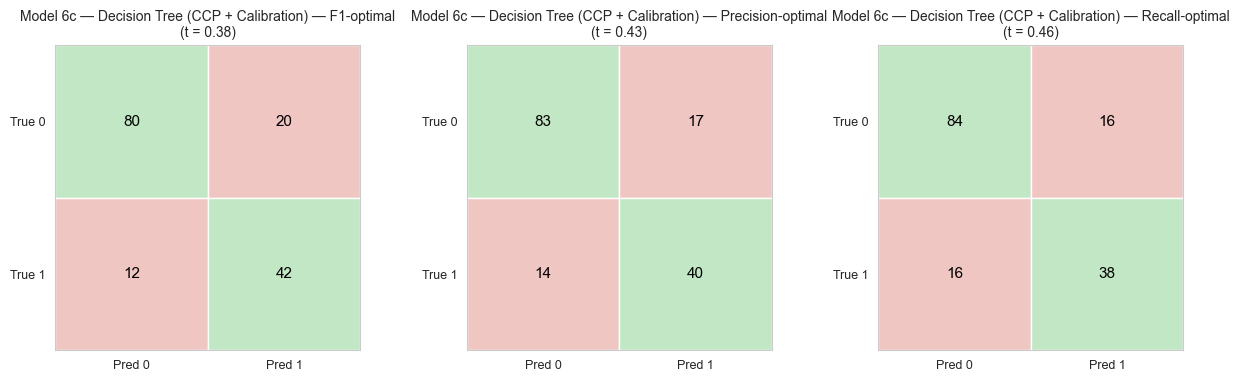


F1-optimal threshold metrics:


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 6c — Decision Tree (CCP + Calibration) —...,0.7922,0.6774,0.8,0.7778,0.7241,0.8491,0.7769



Precision-optimal threshold metrics:


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 6c — Decision Tree (CCP + Calibration) —...,0.7987,0.7018,0.83,0.7407,0.7207,0.8491,0.7769



Recall-optimal threshold metrics:


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 6c — Decision Tree (CCP + Calibration) —...,0.7922,0.7037,0.84,0.7037,0.7037,0.8491,0.7769


In [91]:
# ============================================
# Threshold Optimization — Model 6c — Decision Tree (CCP Pruned + Calibrated)
# ============================================
threshold_model6 = []

# Select model for threshold optimization
y_proba_best = y_proba_6c
model_label  = "Model 6c — Decision Tree (CCP + Calibration)"
# ----------------------------------


# ============================================
# Threshold Optimization
# ============================================

# ---------------------
# Step D — Threshold sweep
# ---------------------
sweep_df = threshold_sweep(y_test, y_proba_best)

# Display preview only (do NOT round real values)
display(sweep_df.round(3).head())


# ---------------------
# Step E — Select thresholds by objective
# ---------------------
t_f1, name_f1 = choose_threshold_by_objective(
    sweep_df, objective="f1_max"
)

t_prec, name_prec = choose_threshold_by_objective(
    sweep_df, objective="precision_at", target=0.70
)

t_rec, name_rec = choose_threshold_by_objective(
    sweep_df, objective="recall_at", target=0.70
)

print(f"F1-optimal threshold: {t_f1:.2f} ({name_f1})")
print(f"Precision≥0.70 threshold: {t_prec:.2f} ({name_prec})")
print(f"Recall≥0.70 threshold: {t_rec:.2f} ({name_rec})")


# ---------------------
# Step F — Evaluation at selected thresholds
# ---------------------
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

res_f1 = show_at_threshold(
    y_test, y_proba_best, t_f1,
    f"{model_label} — F1-optimal",
    ax=axes[0]
)

res_prec = show_at_threshold(
    y_test, y_proba_best, t_prec,
    f"{model_label} — Precision-optimal",
    ax=axes[1]
)

# ----------------------------------
# Store F1-optimal threshold result
# ----------------------------------

threshold_results.append({
    "model": model_label,
    "objective": "F1-optimal",
    "threshold": round(t_f1, 3),
    "accuracy": res_f1["accuracy"],
    "precision": res_f1["precision"],
    "recall": res_f1["recall"],
    "specificity": res_f1["specificity"],
    "f1": res_f1["f1"]
})

threshold_model6.append({
    "model": model_label,
    "threshold": round(t_f1, 3),

    "accuracy": res_f1["accuracy"],
    "precision": res_f1["precision"],
    "recall": res_f1["recall"],
    "specificity": res_f1["specificity"],
    "f1": res_f1["f1"]
})


res_rec = show_at_threshold(
    y_test, y_proba_best, t_rec,
    f"{model_label} — Recall-optimal",
    ax=axes[2]
)

#plt.tight_layout()

plt.subplots_adjust(
    left=0.06,
    right=1,
    wspace=0.35
)
plt.show()

# ---------------------
# Summary tables
# ---------------------
df_model6_threshold = pd.DataFrame(threshold_model6)

print("\nF1-optimal threshold metrics:")
display(pd.DataFrame([res_f1]).round(4))

print("\nPrecision-optimal threshold metrics:")
display(pd.DataFrame([res_prec]).round(4))

print("\nRecall-optimal threshold metrics:")
display(pd.DataFrame([res_rec]).round(4))


### 4.7 Model 7 — Random Forest

This section evaluates Random Forest classifiers as ensemble-based, non-linear models that aggregate multiple decision trees to improve generalization performance and robustness.

Two variants are considered:

* **Model 7a — Baseline Random Forest**
* **Model 7b — Fast-tuned Random Forest (cross-validated)**

All models use the tree-specific preprocessing pipeline defined in Section 3.6 and handle class imbalance using class weighting. Model evaluation is performed on the held-out test set using a fixed decision threshold of `t = 0.50`, prior

In [92]:
# ==========================================
# Model 7 — Random Forest (balanced)
#   7a) Baseline Random Forest
#   7b) Fast-tuned Random Forest (CV)
# ==========================================

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import pandas as pd

rows_rf = []

# ==================================
# 7a) Random Forest — Baseline
# ==================================

pipe_rf_base = Pipeline(steps=[
    ("preprocessor", preprocessor_tree),
    ("classifier", RandomForestClassifier(
        n_estimators=300,
        class_weight="balanced",
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

# Fit base model
pipe_rf_base.fit(X_train, y_train)

# -------- Calibration --------
calibrated_rf_7a = CalibratedClassifierCV(
    estimator=pipe_rf_base,
    method="sigmoid",   # safer than isotonic
    cv=5
)

calibrated_rf_7a.fit(X_train, y_train)

# Evaluation

y_pred_7a  = calibrated_rf_7a.predict(X_test)
y_proba_7a = calibrated_rf_7a.predict_proba(X_test)[:, 1]

rows_rf.append(
    metric_report(
        y_test,
        y_pred_7a,
        y_proba_7a,
        label="Model 7a — Random Forest (Baseline + Calibration)"
    )
)

# ==================================
# 7b) Random Forest — Fast tuning (CV)
# ==================================

param_grid_rf = {
    "classifier__n_estimators": [300, 500],
    "classifier__max_depth": [None, 8, 15],
    "classifier__min_samples_leaf": [1, 5, 20]
}

pipe_rf_tuned = Pipeline(steps=[
    ("preprocessor", preprocessor_tree),
    ("classifier", RandomForestClassifier(
        class_weight="balanced",
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

grid_rf = GridSearchCV(
    pipe_rf_tuned,
    param_grid=param_grid_rf,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_

print("\nBest hyperparameters (Random Forest CV):")
print(grid_rf.best_params_)

# -------- Calibration --------
calibrated_rf_7b = CalibratedClassifierCV(
    estimator=best_rf,
    method="sigmoid",
    cv=5
)

calibrated_rf_7b.fit(X_train, y_train)

# Evaluation
y_pred_7b  = calibrated_rf_7b.predict(X_test)
y_proba_7b = calibrated_rf_7b.predict_proba(X_test)[:, 1]

rows_rf.append(
    metric_report(
        y_test,
        y_pred_7b,
        y_proba_7b,
        label="Model 7b — Random Forest (Fast Tuned + Calibration)"
    )
)

# ==========================================
# Comparison table — Random Forest
# ==========================================

df_model7_compare = pd.DataFrame(rows_rf)
display(df_model7_compare.round(4))



Best hyperparameters (Random Forest CV):
{'classifier__max_depth': None, 'classifier__min_samples_leaf': 20, 'classifier__n_estimators': 300}


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 7a — Random Forest (Baseline + Calibration),0.8052,0.7857,0.91,0.6111,0.6875,0.8672,0.7597
1,Model 7b — Random Forest (Fast Tuned + Calibra...,0.7792,0.7381,0.89,0.5741,0.6458,0.8467,0.7264


,threshold,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,0.01,0.351,0.351,0.0,1.0,0.519,0.867,0.76
1,0.02,0.351,0.351,0.0,1.0,0.519,0.867,0.76
2,0.03,0.351,0.351,0.0,1.0,0.519,0.867,0.76
3,0.04,0.351,0.351,0.0,1.0,0.519,0.867,0.76
4,0.05,0.351,0.351,0.0,1.0,0.519,0.867,0.76


F1-optimal threshold: 0.32 (F1-max)
Precision≥0.70 threshold: 0.35 (precision≥0.7, max recall)
Recall≥0.70 threshold: 0.40 (recall≥0.7, max precision)


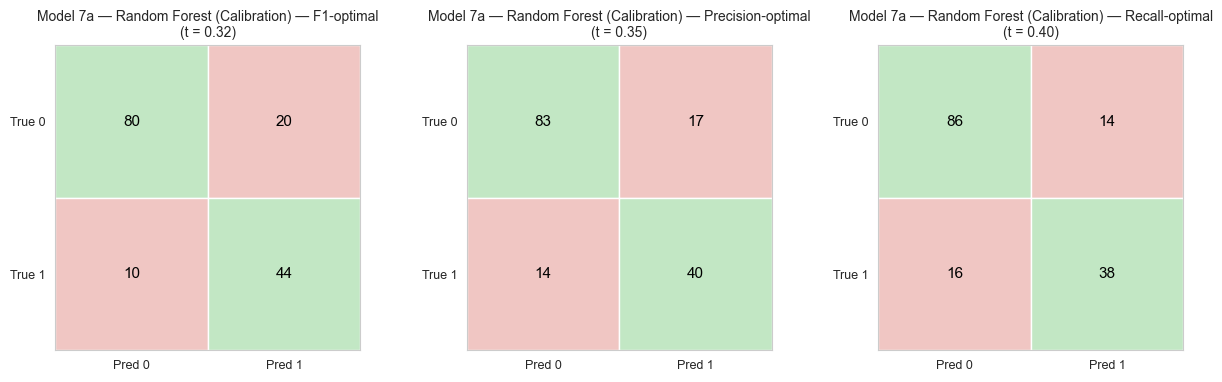


F1-optimal threshold metrics:


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 7a — Random Forest (Calibration) — F1-op...,0.8052,0.6875,0.8,0.8148,0.7458,0.8672,0.7597



Precision-optimal threshold metrics:


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 7a — Random Forest (Calibration) — Preci...,0.7987,0.7018,0.83,0.7407,0.7207,0.8672,0.7597



Recall-optimal threshold metrics:


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 7a — Random Forest (Calibration) — Recal...,0.8052,0.7308,0.86,0.7037,0.717,0.8672,0.7597


In [93]:
# ============================================
# Threshold Optimization — Model 7a — Model 7a — Random Forest (Baseline)
# ============================================
threshold_model7 =[]

# Select model for threshold optimization
y_proba_best = y_proba_7a
model_label  = "Model 7a — Random Forest (Calibration)"
# ----------------------------------


# ============================================
# Threshold Optimization
# ============================================

# ---------------------
# Step D — Threshold sweep
# ---------------------
sweep_df = threshold_sweep(y_test, y_proba_best)

# Display preview only (do NOT round real values)
display(sweep_df.round(3).head())


# ---------------------
# Step E — Select thresholds by objective
# ---------------------
t_f1, name_f1 = choose_threshold_by_objective(
    sweep_df, objective="f1_max"
)

t_prec, name_prec = choose_threshold_by_objective(
    sweep_df, objective="precision_at", target=0.70
)

t_rec, name_rec = choose_threshold_by_objective(
    sweep_df, objective="recall_at", target=0.70
)

print(f"F1-optimal threshold: {t_f1:.2f} ({name_f1})")
print(f"Precision≥0.70 threshold: {t_prec:.2f} ({name_prec})")
print(f"Recall≥0.70 threshold: {t_rec:.2f} ({name_rec})")


# ---------------------
# Step F — Evaluation at selected thresholds
# ---------------------
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

res_f1 = show_at_threshold(
    y_test, y_proba_best, t_f1,
    f"{model_label} — F1-optimal",
    ax=axes[0]
)

# ----------------------------------
# Store F1-optimal threshold result
# ----------------------------------

threshold_results.append({
    "model": model_label,
    "objective": "F1-optimal",
    "threshold": round(t_f1, 3),
    "accuracy": res_f1["accuracy"],
    "precision": res_f1["precision"],
    "recall": res_f1["recall"],
    "specificity": res_f1["specificity"],
    "f1": res_f1["f1"]
})

threshold_model7.append({
    "model": model_label,
    "threshold": round(t_f1, 3),

    "accuracy": res_f1["accuracy"],
    "precision": res_f1["precision"],
    "recall": res_f1["recall"],
    "specificity": res_f1["specificity"],
    "f1": res_f1["f1"]
})


res_prec = show_at_threshold(
    y_test, y_proba_best, t_prec,
    f"{model_label} — Precision-optimal",
    ax=axes[1]
)

res_rec = show_at_threshold(
    y_test, y_proba_best, t_rec,
    f"{model_label} — Recall-optimal",
    ax=axes[2]
)

#plt.tight_layout()

plt.subplots_adjust(
    left=0.06,
    right=1,
    wspace=0.35
)
plt.show()

# ---------------------
# Summary tables
# ---------------------

df_model7_threshold = pd.DataFrame(threshold_model7)

print("\nF1-optimal threshold metrics:")
display(pd.DataFrame([res_f1]).round(4))

print("\nPrecision-optimal threshold metrics:")
display(pd.DataFrame([res_prec]).round(4))

print("\nRecall-optimal threshold metrics:")
display(pd.DataFrame([res_rec]).round(4))

### 4.8 Model 8 — Boosting Models

This section evaluates boosting-based classifiers that sequentially combine weak learners to improve predictive performance by focusing on previously misclassified samples.

Two variants are considered:

* **Model 8a — Gradient Boosting**
* **Model 8b — XGBoost (fast tuned)**

All models use the tree-specific preprocessing pipeline defined in Section 3.6 and handle class imbalance using class weighting when supported. Model evaluation is performed on the held-out test set using a fixed decision threshold of `t = 0.50`, prior to decision threshold optimization.

In [94]:
# ==========================================
# Model 8 — Boosting Models
#   8a) Gradient Boosting (baseline)
#   8b) XGBoost (fast tuned)
# ==========================================

from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import pandas as pd

rows_boost = []

# ==================================
# 8a) Gradient Boosting — Baseline
# ==================================

pipe_gb = Pipeline(steps=[
    ("preprocessor", preprocessor_tree),
    ("classifier", GradientBoostingClassifier(
        random_state=RANDOM_STATE
    ))
])

pipe_gb.fit(X_train, y_train)

# -------- Calibration --------
calibrated_gb_8a = CalibratedClassifierCV(
    estimator=pipe_gb,
    method="sigmoid",   # safer than isotonic
    cv=5
)

calibrated_gb_8a.fit(X_train, y_train)

# Evaluation
y_pred_8a  = calibrated_gb_8a.predict(X_test)
y_proba_8a = calibrated_gb_8a.predict_proba(X_test)[:, 1]

rows_boost.append(
    metric_report(
        y_test,
        y_pred_8a,
        y_proba_8a,
        label="Model 8a — Gradient Boosting + Calibration"
    )
)

# ==================================
# 8b) XGBoost — Fast tuning (CV)
# ==================================

pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

pipe_xgb = Pipeline(steps=[
    ("preprocessor", preprocessor_tree),
    ("classifier", XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        scale_pos_weight=pos_weight,
        #use_label_encoder=False,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

param_grid_xgb = {
    "classifier__n_estimators": [300, 500],
    "classifier__max_depth": [3, 5],
    "classifier__learning_rate": [0.05, 0.1],
    "classifier__subsample": [0.8, 1.0],
    "classifier__colsample_bytree": [0.8, 1.0]
}

grid_xgb = GridSearchCV(
    pipe_xgb,
    param_grid=param_grid_xgb,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1
)

grid_xgb.fit(X_train, y_train)

best_xgb = grid_xgb.best_estimator_

print("\nBest hyperparameters (XGBoost CV):")
print(grid_xgb.best_params_)
# -------- Calibration --------
calibrated_xgb_8b = CalibratedClassifierCV(
    estimator=best_xgb,
    method="sigmoid",
    cv=5
)

calibrated_xgb_8b.fit(X_train, y_train)

# Evaluation
y_pred_8b  = calibrated_xgb_8b.predict(X_test)
y_proba_8b = calibrated_xgb_8b.predict_proba(X_test)[:, 1]

rows_boost.append(
    metric_report(
        y_test,
        y_pred_8b,
        y_proba_8b,
        label="Model 8b — XGBoost (Fast Tuned + Calibration)"
    )
)

# ==========================================
# Comparison table — Boosting Models
# ==========================================

df_model8_compare = pd.DataFrame(rows_boost)
display(df_model8_compare.round(4))



Best hyperparameters (XGBoost CV):
{'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__n_estimators': 300, 'classifier__subsample': 0.8}


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 8a — Gradient Boosting + Calibration,0.7987,0.7949,0.92,0.5741,0.6667,0.8681,0.7936
1,Model 8b — XGBoost (Fast Tuned + Calibration),0.8117,0.8049,0.92,0.6111,0.6947,0.8550,0.7609


,threshold,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,0.01,0.351,0.351,0.00,1.0,0.519,0.868,0.794
1,0.02,0.351,0.351,0.00,1.0,0.519,0.868,0.794
2,0.03,0.351,0.351,0.00,1.0,0.519,0.868,0.794
3,0.04,0.351,0.351,0.00,1.0,0.519,0.868,0.794
4,0.05,0.357,0.353,0.01,1.0,0.522,0.868,0.794


F1-optimal threshold: 0.35 (F1-max)
Precision≥0.70 threshold: 0.37 (precision≥0.7, max recall)
Recall≥0.70 threshold: 0.43 (recall≥0.7, max precision)


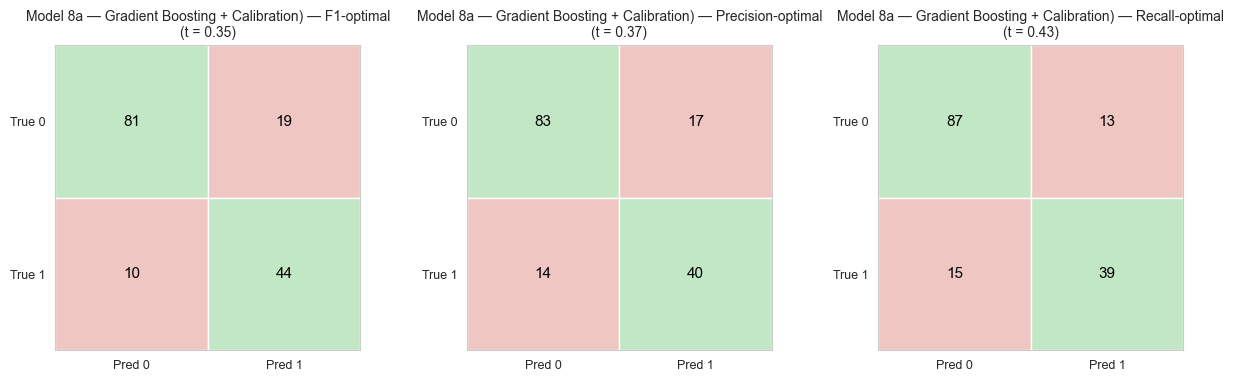


F1-optimal threshold metrics:


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 8a — Gradient Boosting + Calibration) — ...,0.8117,0.6984,0.81,0.8148,0.7521,0.8681,0.7936



Precision-optimal threshold metrics:


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 8a — Gradient Boosting + Calibration) — ...,0.7987,0.7018,0.83,0.7407,0.7207,0.8681,0.7936



Recall-optimal threshold metrics:


,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model 8a — Gradient Boosting + Calibration) — ...,0.8182,0.75,0.87,0.7222,0.7358,0.8681,0.7936


In [95]:
# ============================================
# Threshold Optimization — Model Selection
# ============================================

threshold_model8 = []

# Select model for threshold optimization
y_proba_best = y_proba_8a
model_label  = "Model 8a — Gradient Boosting + Calibration)"
# ----------------------------------

# ============================================
# Threshold Optimization
# ============================================

# ---------------------
# Step D — Threshold sweep
# ---------------------
sweep_df = threshold_sweep(y_test, y_proba_best)

# Display preview only (do NOT round real values)
display(sweep_df.round(3).head())

# ---------------------
# Step E — Select thresholds by objective
# ---------------------
t_f1, name_f1 = choose_threshold_by_objective(
    sweep_df, objective="f1_max"
)

t_prec, name_prec = choose_threshold_by_objective(
    sweep_df, objective="precision_at", target=0.70
)

t_rec, name_rec = choose_threshold_by_objective(
    sweep_df, objective="recall_at", target=0.70
)

print(f"F1-optimal threshold: {t_f1:.2f} ({name_f1})")
print(f"Precision≥0.70 threshold: {t_prec:.2f} ({name_prec})")
print(f"Recall≥0.70 threshold: {t_rec:.2f} ({name_rec})")

# ---------------------
# Step F — Evaluation at selected thresholds
# ---------------------
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

res_f1 = show_at_threshold(
    y_test, y_proba_best, t_f1,
    f"{model_label} — F1-optimal",
    ax=axes[0]
)

# ----------------------------------
# Store F1-optimal threshold result
# ----------------------------------

threshold_results.append({
    "model": model_label,
    "objective": "F1-optimal",
    "threshold": round(t_f1, 3),
    "accuracy": res_f1["accuracy"],
    "precision": res_f1["precision"],
    "recall": res_f1["recall"],
    "specificity": res_f1["specificity"],
    "f1": res_f1["f1"]
})

threshold_model8.append({
    "model": model_label,
    "threshold": round(t_f1, 3),

    "accuracy": res_f1["accuracy"],
    "precision": res_f1["precision"],
    "recall": res_f1["recall"],
    "specificity": res_f1["specificity"],
    "f1": res_f1["f1"]
})

res_prec = show_at_threshold(
    y_test, y_proba_best, t_prec,
    f"{model_label} — Precision-optimal",
    ax=axes[1]
)

res_rec = show_at_threshold(
    y_test, y_proba_best, t_rec,
    f"{model_label} — Recall-optimal",
    ax=axes[2]
)

#plt.tight_layout()

plt.subplots_adjust(
    left=0.06,
    right=1,
    wspace=0.35
)
plt.show()
# ---------------------
# Summary tables
# ---------------------

df_model8_threshold = pd.DataFrame(threshold_model8)

print("\nF1-optimal threshold metrics:")
display(pd.DataFrame([res_f1]).round(4))

print("\nPrecision-optimal threshold metrics:")
display(pd.DataFrame([res_prec]).round(4))

print("\nRecall-optimal threshold metrics:")
display(pd.DataFrame([res_rec]).round(4))



## 5. Final Model Comparison

### 5.1 Model Ranking Based on Probability Performance (PR-AUC)
Models are first compared based on PR-AUC, which is more informative than ROC-AUC for moderately imbalanced clinical datasets. This evaluation reflects each model’s intrinsic ability to separate positive and negative cases independent of any fixed decision threshold.

In [102]:
# ==========================================
# Final Model Comparison — Full Metrics
# PR-AUC ranked + highlighted + family tags
# ==========================================

import pandas as pd
from IPython.display import display, HTML

# ----------------------------------
# 1) Combine all model comparison tables
# ----------------------------------

dfs = [
    df_model0_compare,   # Model 0 — Rule-based
    df_model1_compare,   # Model 1 — Logistic
    df_model2_compare,   # Model 2 — SGD Logistic
    df_model3_compare,   # Model 3 — SVM
    df_model4_compare,   # Model 4 — KNN
    df_model5_compare,   # Model 5 — Polynomial Logistic
    df_model6_compare,   # Model 6 — Decision Tree
    df_model7_compare,   # Model 7 — Random Forest
    df_model8_compare    # Model 8 — Boosting
]

df_all_models = (
    pd.concat(dfs, ignore_index=True)
      .drop_duplicates(subset=["model"], keep="last")
)

# ----------------------------------
# 2) Rank by PR-AUC
# ----------------------------------

df_ranked = (
    df_all_models
    .sort_values(by="pr_auc", ascending=False)
    .reset_index(drop=True)
)

# ----------------------------------
# 3) Assign model family
# ----------------------------------

def extract_family(model_name):

    if model_name.startswith("Model 0"):
        return "Rule-based"

    if model_name.startswith("Model 1"):
        return "Logistic"

    if model_name.startswith("Model 2"):
        return "SGD Logistic"

    if model_name.startswith("Model 3"):
        return "SVM"

    if model_name.startswith("Model 4"):
        return "KNN"

    if model_name.startswith("Model 5"):
        return "Poly Logistic"

    if model_name.startswith("Model 6"):
        return "Decision Tree"

    if model_name.startswith("Model 7"):
        return "Random Forest"

    if model_name.startswith("Model 8"):
        return "Boosting"

    return "Other"


df_ranked["Family"] = df_ranked["model"].apply(extract_family)

# ----------------------------------
# 4) Family colors (soft background)
# ----------------------------------

family_colors = {
    "Rule-based":     "#ACAEAF",
    "Logistic":       "#D5B6DA",
    "Poly Logistic":  "#EDE7F6",
    "SGD Logistic":   "#E1F5FE",
    "SVM":            "#C5CCD1",
    "Decision Tree":  "#E8F5E9",
    "Random Forest":  "#FFFDE7",
    "Boosting":       "#FBE9E7",
    "KNN":            "#E0F2F1"
}

def highlight_family(row):
    color = family_colors.get(row["Family"], "#FFFFFF")
    return [f"background-color: {color}"] * len(row)

# ----------------------------------
# 5) Highlight PR-AUC column
# ----------------------------------

def highlight_pr_auc(col):
    return [
        "background-color: #FFCDD2; font-weight: bold"
        if col.name == "pr_auc" else ""
        for _ in col
    ]

# ----------------------------------
# 6) Add family icon tags
# ----------------------------------

family_icon = {
    "Rule-based": "⚫",
    "Logistic": "🟣",
    "Poly Logistic": "🟣",
    "SGD Logistic": "🔵",
    "SVM": "🔵",
    "Decision Tree": "🟢",
    "Random Forest": "🟡",
    "Boosting": "🟠",
    "KNN": "🟤"
}

df_ranked["FamilyTag"] = df_ranked["Family"].map(family_icon).fillna("⬜")

# ----------------------------------
# 7) Styled display
# ----------------------------------

styled_df = (
    df_ranked[
        [
            "model",
            "accuracy",
            "precision",
            "recall",
            "specificity",
            "f1",
            "roc_auc",
            "pr_auc",
            "Family",
            "FamilyTag"
        ]
    ]
    .style
    .apply(highlight_family, axis=1)
    .apply(highlight_pr_auc, axis=0)
    .format({
        "accuracy": "{:.3f}",
        "precision": "{:.3f}",
        "recall": "{:.3f}",
        "specificity": "{:.3f}",
        "f1": "{:.3f}",
        "roc_auc": "{:.3f}",
        "pr_auc": "{:.3f}",
    })
)

# ----------------------------------
# 8) Title + display
# ----------------------------------

display(HTML("""
<h3 style='
    text-align:center;
    font-weight:600;
    margin-bottom:6px;
    margin-top:8px;
'>
Final Model Performance Comparison (PR-AUC Ranked)
</h3>
"""))

display(styled_df)


,model,accuracy,precision,recall,specificity,f1,roc_auc,pr_auc,Family,FamilyTag
0,Model 8a — Gradient Boosting + Calibration,0.799,0.795,0.574,0.920,0.667,0.868,0.794,Boosting,🟠
1,Model 6c — Decision Tree (CCP Pruned + Calibration),0.786,0.733,0.611,0.880,0.667,0.849,0.777,Decision Tree,🟢
2,Model 3b — RBF SVC (CV + Calibration),0.773,0.721,0.574,0.880,0.639,0.864,0.776,SVM,🔵
3,Model 5b — Polynomial Logistic L2 (CV),0.786,0.672,0.759,0.800,0.713,0.868,0.774,Poly Logistic,🟣
4,Model 1c — Logistic L1 (CV),0.786,0.672,0.759,0.800,0.713,0.872,0.772,Logistic,🟣
5,Model 1a — Logistic (No Reg),0.786,0.672,0.759,0.800,0.713,0.871,0.771,Logistic,🟣
6,Model 1b — Logistic L2 (CV),0.786,0.672,0.759,0.800,0.713,0.871,0.771,Logistic,🟣
7,Model 2c — SGD Logistic L1,0.786,0.714,0.648,0.860,0.680,0.873,0.769,SGD Logistic,🔵
8,Model 5a — Polynomial Logistic (No Reg),0.792,0.672,0.796,0.790,0.729,0.855,0.766,Poly Logistic,🟣
9,Model 8b — XGBoost (Fast Tuned + Calibration),0.812,0.805,0.611,0.920,0.695,0.855,0.761,Boosting,🟠


### 5.2 Operational Performance After Threshold Optimization (F1-Optimized)
In the second stage, the top-performing models from each model family are evaluated at their F1-optimal decision thresholds. This analysis reflects realistic deployment behavior, where decision thresholds are tuned to balance precision and recall in alignment with clinical objectives.

In [105]:
# ==========================================
# Final Threshold Optimization Summary
# (F1-optimal thresholds)
# ==========================================

import pandas as pd
from IPython.display import display, HTML

# ----------------------------------
# Build DataFrame
# ----------------------------------
# ----------------------------------
# Build DataFrame
# ----------------------------------

threshold_summary_rows = [
    df_model0_threshold,   # Model 0 — Rule-based
    df_model1_threshold,   # Model 1 — Logistic
    df_model2_threshold,   # Model 2 — SGD Logistic
    df_model3_threshold,   # Model 3 — SVM
    df_model4_threshold,   # Model 4 — KNN
    df_model5_threshold,   # Model 5 — Polynomial Logistic
    df_model6_threshold,   # Model 6 — Decision Tree
    df_model7_threshold,   # Model 7 — Random Forest
    df_model8_threshold,   # Model 8 — Boosting
]

df_threshold_summary = pd.concat(
    threshold_summary_rows,
    ignore_index=True
)


# ----------------------------------
# Assign model family
# ----------------------------------

def extract_family(model_name):

    if model_name.startswith("Model 0"):
        return "Rule-based"

    if model_name.startswith("Model 1"):
        return "Logistic"

    if model_name.startswith("Model 2"):
        return "SGD Logistic"

    if model_name.startswith("Model 3"):
        return "SVM"

    if model_name.startswith("Model 4"):
        return "KNN"

    if model_name.startswith("Model 5"):
        return "Poly Logistic"

    if model_name.startswith("Model 6"):
        return "Decision Tree"

    if model_name.startswith("Model 7"):
        return "Random Forest"

    if model_name.startswith("Model 8"):
        return "Boosting"

    return "Other"


df_threshold_summary["Family"] = df_threshold_summary["model"].apply(extract_family)


# ----------------------------------
# Rank by F1 score
# ----------------------------------

df_threshold_ranked = (
    df_threshold_summary
    .sort_values(by="f1", ascending=False)
    .reset_index(drop=True)
)


# ----------------------------------
# Family colors
# ----------------------------------

family_colors = {
    "Logistic":       "#D5B6DA",
    "Poly Logistic":  "#EDE7F6",
    "SGD Logistic":   "#E1F5FE",
    "SVM":            "#C5CCD1",
    "Decision Tree":  "#E8F5E9",
    "Random Forest":  "#FFFDE7",
    "Boosting":       "#FBE9E7",
    "KNN":            "#E0F2F1",
    "Rule-based":     "#ACAEAF" 
}


def highlight_family(row):
    color = family_colors.get(row["Family"], "#FFFFFF")
    return [f"background-color: {color}"] * len(row)


# ----------------------------------
# Highlight F1 column (main metric)
# ----------------------------------

def highlight_f1(col):
    return [
        "background-color: #FFCDD2; font-weight: bold"
        if col.name == "f1" else ""
        for _ in col
    ]


# ----------------------------------
# Style table
# ----------------------------------

styled_threshold_df = (
    df_threshold_ranked[
        [
            "model",
            "threshold",
            "accuracy",
            "precision",
            "recall",
            "specificity",
            "f1",
            "Family"
        ]
    ]
    .style
    .apply(highlight_family, axis=1)
    .apply(highlight_f1, axis=0)
    .format({
        "threshold": "{:.3f}",
        "accuracy": "{:.3f}",
        "precision": "{:.3f}",
        "recall": "{:.3f}",
        "specificity": "{:.3f}",
        "f1": "{:.3f}"
    })
)


# ----------------------------------
# Display
# ----------------------------------

display(HTML("""
<h3 style='
    text-align:center;
    font-weight:600;
    margin-bottom:2px;
    margin-top:6px;
'>
Threshold Optimization Summary (F1-Optimal)
</h3>
"""))

display(styled_threshold_df)


,model,threshold,accuracy,precision,recall,specificity,f1,Family
0,Model 1c — Logistic L1 (CV),0.400,0.825,0.690,0.907,0.780,0.784,Logistic
1,Model 5b — Polynomial Logistic L2 (CV),0.380,0.805,0.671,0.870,0.770,0.758,Poly Logistic
2,Model 8a — Gradient Boosting + Calibration),0.350,0.812,0.698,0.815,0.810,0.752,Boosting
3,Model 7a — Random Forest (Calibration),0.320,0.805,0.688,0.815,0.800,0.746,Random Forest
4,Model 2c — SGD Logistic L1,0.170,0.773,0.620,0.907,0.700,0.737,SGD Logistic
5,Model 3b — RBF SVC (CV + Calibration),0.270,0.779,0.639,0.852,0.740,0.730,SVM
6,Model 6c — Decision Tree (CCP + Calibration),0.380,0.792,0.677,0.778,0.800,0.724,Decision Tree
7,Model 4 — KNN (CV optimized + Calibration),0.260,0.747,0.603,0.815,0.710,0.693,KNN
8,Model 0 — Insulin Threshold Baseline,0.130,0.583,0.449,0.939,0.397,0.608,Rule-based


## 5. Conclusion

Multiple classification model families were evaluated using a two-stage evaluation strategy. In the first stage, models were ranked based on **PR-AUC**, which is more appropriate for imbalanced clinical datasets. In the second stage, selected models were evaluated under **F1-optimal decision thresholds** to reflect deployment-oriented performance.

After probability calibration, **Gradient Boosting with calibration (Model 8a)** achieved the highest PR-AUC score (**PR-AUC = 0.794**), followed closely by **CCP-pruned Decision Trees with calibration (Model 6c)** and **RBF SVM with calibration (Model 3b)**. This indicates that ensemble-based methods and calibrated non-linear models are particularly effective at ranking high-risk patients in this dataset.

When focusing on operational performance after threshold optimization, **Logistic Regression with regularization (Model 1c)** achieved the strongest balanced performance with the highest F1 score (**F1 = 0.784**) at an optimized threshold of **0.40**. This result demonstrates that, despite being a simpler linear model, Logistic Regression remains highly competitive when paired with proper preprocessing and threshold tuning.

**Gradient Boosting (calibrated)** also remained robust after threshold optimization (**F1 = 0.752**), confirming its stability across both ranking-based and threshold-based evaluation criteria. Polynomial Logistic Regression and CCP-pruned Decision Trees showed consistent mid-to-high F1 performance, suggesting that moderate non-linearity and controlled tree complexity can offer reliable trade-offs between flexibility and interpretability.

In contrast, **KNN** and unpruned tree variants exhibited weaker performance, reflecting their sensitivity to class imbalance, local density effects, and probability calibration challenges in medical tabular data.

The rule-based **Insulin Threshold Baseline (Model 0)** achieved high recall but very low precision and PR-AUC, confirming that insulin alone contains limited predictive signal and should be treated as a clinical intuition benchmark rather than a production-ready solution.

Overall, the results highlight that:

* **PR-AUC ranking and threshold-optimized F1 performance capture different but complementary aspects of model quality.**
* **Probability calibration improves model comparability and stabilizes ranking performance, especially for ensemble and kernel-based models.**
* **Threshold optimization is critical for deployment-oriented evaluation and can allow simpler models to outperform more complex alternatives in real-world decision settings.**
* **Well-calibrated Logistic Regression and Boosting models provide the most reliable balance between performance, interpretability, and operational usability.**

These findings emphasize that in clinical risk prediction tasks, **deployment-aware evaluation (calibration + threshold tuning + imbalance-aware metrics)** is as important as raw predictive accuracy.
